In [1]:
%matplotlib widget
%matplotlib inline
import torch
import torch.nn as nn
import pickle
import time
import copy
import os
from queue import LifoQueue
from sklearn.cluster import DBSCAN
from sklearn.mixture import GaussianMixture
from sklearn.metrics import davies_bouldin_score
from scipy.stats import kurtosis
import matplotlib.pyplot as plt
import numpy as np
import sys
from sklearn.tree import DecisionTreeClassifier
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

from tqdm.notebook import tqdm
from sklearn.metrics import pairwise_distances
import network.cpc
from network.cpc import CDCK2
from utils.MatplotlibUtils import reduce_dims_and_plot
from utils.ClassificationUtiols import onehot_coding
from soft_decision_tree.sdt_model import SDT
from sklearn import tree as tt

# IPython.OutputArea.auto_scroll_threshold = 9999;

# Load the model and the dataset

In [2]:
model_path = r'/home/eitan.k/EntangledExplainableClustering/knn_loss_batch_512_k_128/models/epoch_40.pt'
dataset_path = r'/home/eitan.k/EntangledExplainableClustering/knn_loss_batch_512_k_128/data/test_data_protocol_4.file'

print(f"Load the model from: {model_path}")
model = torch.load(model_path, map_location='cpu')

with open(dataset_path, 'rb') as fp:
    dataset = pickle.load(fp)

all_sensors = dataset.dataset.all_signals    
print(f"sensor names: ({len(all_sensors)} total)")

for s in all_sensors:
    print(f"- {s}")
    
print(f"Multihorizon size of the model: {model.timestep}")
print(f"Test split ratio: {len(dataset) / len(dataset.dataset)}")
print(f"Total number of windows in the dataset (without splitting): {len(dataset.dataset)}")

Load the model from: /home/eitan.k/EntangledExplainableClustering/knn_loss_batch_512_k_128/models/epoch_40.pt
sensor names: (18 total)
- speed
- steering_angle
- wheel_speed_0
- wheel_speed_1
- wheel_speed_2
- wheel_speed_3
- accelerometer_0
- accelerometer_1
- accelerometer_2
- gyro_0
- gyro_1
- gyro_2
- gyro_bias_0
- gyro_bias_1
- gyro_bias_2
- gyro_uncalibrated_0
- gyro_uncalibrated_1
- gyro_uncalibrated_2
Multihorizon size of the model: 30
Test split ratio: 0.2
Total number of windows in the dataset (without splitting): 101465


In [3]:
batch_size = 500
loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=False)

# Extract representations

In [4]:
projections = torch.tensor([])
samples = torch.tensor([])
device = 'cuda'
model = model.to(device).eval()

with torch.no_grad():
    bar = tqdm(total=len(loader.dataset))
    for batch in loader:
        hidden = CDCK2.init_hidden(len(batch))
        batch = batch.to(device)
        hidden = hidden.to(device)

        y = model.predict(batch, hidden).detach().cpu()
        projections = torch.cat([projections, y.detach().cpu()])
        samples = torch.cat([samples, batch.detach().cpu()])
        bar.update(y.shape[0])

# Fit GMM and calculate indices

In [5]:
scores = []
best_score = float('inf')
clusters = None
range_ = list(range(5, 20))
for k in tqdm(range_):
    y = GaussianMixture(n_components=k).fit_predict(projections)
    cur_score = davies_bouldin_score(projections, y)
    scores.append(cur_score)
    
    if cur_score < best_score:
        best_score = cur_score
        clusters = y

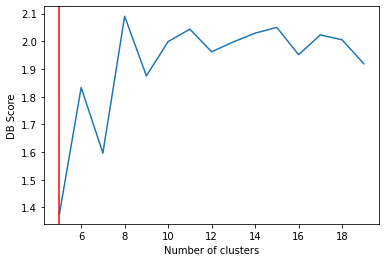

{0, 1, 2, 3, 4}


In [6]:
plt.figure()
plt.xlabel('Number of clusters')
plt.ylabel('DB Score')
plt.plot(range_, scores)
best_k = range_[np.argmin(scores)]
plt.axvline(best_k, color='r')
plt.show()

labels = set(clusters)
print(labels)

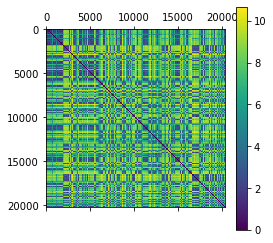

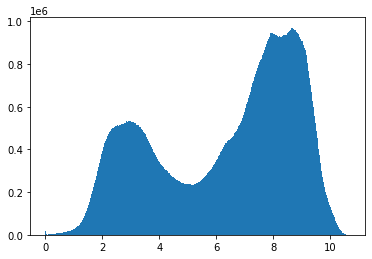

In [7]:
distances = pairwise_distances(projections)
# distances = np.triu(distances)
distances_f = distances.flatten()

plt.matshow(distances)
plt.colorbar()
plt.figure()
plt.hist(distances_f[distances_f > 0], bins=1000)
plt.show()

# Visualize with T-SNE

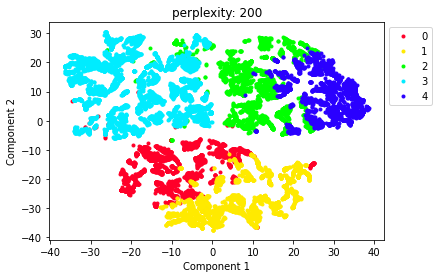

In [8]:
perplexity = 200

p = reduce_dims_and_plot(projections,
                         y=clusters,
                         title=f'perplexity: {perplexity}',
                         file_name=None,
                         perplexity=perplexity,
                         library='Multicore-TSNE',
                         perform_PCA=False,
                         projected=None,
                         figure_type='2d',
                         show_figure=True,
                         close_figure=False,
                         text=None)    

# Train a Soft-Decision-Tree given the self-labels

## Prepare the dataset

In [9]:
# unnormalized_samples = samples.clone()

# for col, sensor in enumerate(tqdm(dataset.dataset.all_signals)):
#     denormalizer = dataset.dataset.get_denormalization_for_sensor(sensor)
#     unnormalized_samples[:, col, :] = denormalizer(unnormalized_samples[:, col, :])

sampled = samples[..., range(0, samples.shape[-1], 200)]

samples_f = sampled.flatten(1)
tree_dataset = list(zip(samples_f, clusters))
batch_size = 2000
tree_loader = torch.utils.data.DataLoader(tree_dataset, batch_size=batch_size, shuffle=True)

# Define how we prune the weights of a node

In [10]:
def prune_node(node_weights, factor=1):
    w = node_weights.cpu().detach().numpy()
    mean_ = np.mean(w)
    std_ = np.std(w)
    node_weights[((mean_ - std_ * factor) < node_weights) & (node_weights < (mean_ + std_ * factor))] = 0
    return node_weights

def prune_node_keep(node_weights, keep=4):
    w = node_weights.cpu().detach().numpy()
    throw_idx = np.argsort(abs(w))[:-keep]
    node_weights[throw_idx] = 0
    return node_weights

def prune_tree(tree_, factor):
    new_weights = tree_.inner_nodes.weight.clone()
    for i in range(new_weights.shape[0]):
        res = prune_node_keep(new_weights[i, :], factor)
        new_weights[i, :] = res

    with torch.no_grad():
        tree_.inner_nodes.weight.copy_(new_weights)
        
def sparseness(x):
    s = []
    for i in range(x.shape[0]):
        x_ = x[i, :]
        sp = (len(x_) - torch.norm(x_, 0).item()) / len(x_)
        s.append(sp)
    return np.mean(s)

def compute_regularization_by_level(tree):
    total_reg = 0
    for i in range(tree.inner_nodes.weight.shape[0]):
        cur_level = np.floor(np.log2(i+1))
        node_reg = torch.norm(tree.inner_nodes.weight[i].view(-1), 2)
        total_reg += 2**(-cur_level) * node_reg
    return total_reg

def show_sparseness(tree):
    avg_sp = sparseness(tree.inner_nodes.weight)
    print(f"Average sparseness: {avg_sp}")
    layer = 0
    sps = []
    for i in range(tree.inner_nodes.weight.shape[0]):
        cur_layer = int(np.floor(np.log2(i+1)))
        if cur_layer != layer:
            print(f"layer {layer}: {np.mean(sps)}")
            sps = []
            layer = cur_layer

        x_ = tree.inner_nodes.weight[i, :]
        sp = (len(x_) - torch.norm(x_, 0).item()) / len(x_)
        sps.append(sp)
        
    return avg_sp

## Training configurations

In [11]:
def do_epoch(model, loader, device, log_interval, losses, accs, epoch, iteration):
    model = model.train()
    for batch_idx, (data, target) in enumerate(loader):
        iteration += 1
        data, target = data.to(device), target.to(device)

        output, penalty = tree.forward(data)

        # Loss
        loss_tree = criterion(output, target.view(-1))

        # Penalty
        loss_tree += penalty

        # Sparse regularization
#         fc_params = torch.cat([x.view(-1) for x in tree.inner_nodes.parameters()])
#         regularization = sparsity_lamda * torch.norm(fc_params, 2)
        regularization = sparsity_lamda * compute_regularization_by_level(tree)
        loss = loss_tree

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        losses.append(loss.item())

        pred = output.data.max(1)[1]
        correct = pred.eq(target.view(-1).data).sum()
        accs.append(correct.item() / data.size()[0])

        # Print training status
        if batch_idx % log_interval == 0:
            print(f"Epoch: {epoch:02d} | Batch: {batch_idx:03d} / {len(loader):03d} | Total loss: {loss.item():.3f} | Reg loss: {regularization.item():.3f} | Tree loss: {loss_tree.item():.3f} | Accuracy: {correct.item() / data.size()[0]:03f} | {round((time.time() - start_time) / iteration, 3)} sec/iter")
            
    return iteration


In [12]:
lr = 5e-3
weight_decay = 5e-4
sparsity_lamda = 2e-3
epochs = 500
output_dim = len(set(clusters))
log_interval = 1
tree_depth = 10

In [13]:
tree = SDT(input_dim=samples_f.shape[1], output_dim=len(labels), depth=tree_depth, lamda=1e-3, use_cuda=True)
optimizer = torch.optim.Adam(tree.parameters(),
                                 lr=lr,
                                 weight_decay=weight_decay)
criterion = nn.CrossEntropyLoss()
tree = tree.to(device)
clf = DecisionTreeClassifier(max_depth=tree_depth).fit(samples_f, clusters)
print(f"DT accuracy: {clf.score(samples_f, clusters)}")
tree.initialize_from_decision_tree(clf)

DT accuracy: 0.9809786625930124


In [14]:
losses = []
accs = []
sparsity = []

In [ ]:
start_time = time.time()
iteration = 0
for epoch in range(epochs):
    # Training
    avg_sp = show_sparseness(tree)
    sparsity.append(avg_sp)
    iteration = do_epoch(tree, tree_loader, device, log_interval, losses, accs, epoch, iteration)
    
    if epoch % 1 == 0:
        prune_tree(tree, factor=5)
        

Average sparseness: 0.21654434201217304
layer 0: 0.988950276243094
layer 1: 0.988950276243094
layer 2: 0.988950276243094
layer 3: 0.988950276243094
layer 4: 0.988950276243094
layer 5: 0.9271408839779005
layer 6: 0.6180939226519337
layer 7: 0.3399516574585636
layer 8: 0.158386567679558
Epoch: 00 | Batch: 000 / 011 | Total loss: 1.610 | Reg loss: 0.019 | Tree loss: 1.610 | Accuracy: 0.289000 | 5.613 sec/iter
Epoch: 00 | Batch: 001 / 011 | Total loss: 1.592 | Reg loss: 0.018 | Tree loss: 1.592 | Accuracy: 0.286500 | 3.261 sec/iter
Epoch: 00 | Batch: 002 / 011 | Total loss: 1.578 | Reg loss: 0.018 | Tree loss: 1.578 | Accuracy: 0.393000 | 2.622 sec/iter
Epoch: 00 | Batch: 003 / 011 | Total loss: 1.556 | Reg loss: 0.018 | Tree loss: 1.556 | Accuracy: 0.399000 | 2.268 sec/iter
Epoch: 00 | Batch: 004 / 011 | Total loss: 1.540 | Reg loss: 0.018 | Tree loss: 1.540 | Accuracy: 0.398500 | 2.066 sec/iter
Epoch: 00 | Batch: 005 / 011 | Total loss: 1.537 | Reg loss: 0.018 | Tree loss: 1.537 | Accura

Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
Epoch: 05 | Batch: 000 / 011 | Total loss: 1.550 | Reg loss: 0.016 | Tree loss: 1.550 | Accuracy: 0.379500 | 1.491 sec/iter
Epoch: 05 | Batch: 001 / 011 | Total loss: 1.543 | Reg loss: 0.016 | Tree loss: 1.543 | Accuracy: 0.368500 | 1.487 sec/iter
Epoch: 05 | Batch: 002 / 011 | Total loss: 1.518 | Reg loss: 0.016 | Tree loss: 1.518 | Accuracy: 0.431000 | 1.485 sec/iter
Epoch: 05 | Batch: 003 / 011 | Total loss: 1.514 | Reg loss: 0.016 | Tree loss: 1.514 | Accuracy: 0.403000 | 1.484 sec/iter
Epoch: 05 | Batch: 004 / 011 | Total loss: 1.501 | Reg loss: 0.016 | Tree loss: 1.501 | Accuracy: 0.406000 | 1.482 sec/iter
Epoch: 05 | Batch: 005 / 011 | Total loss: 1.477 | Reg loss: 0.016 | Tree loss: 1.477 | A

Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
Epoch: 10 | Batch: 000 / 011 | Total loss: 1.497 | Reg loss: 0.017 | Tree loss: 1.497 | Accuracy: 0.380500 | 1.478 sec/iter
Epoch: 10 | Batch: 001 / 011 | Total loss: 1.473 | Reg loss: 0.017 | Tree loss: 1.473 | Accuracy: 0.405500 | 1.476 sec/iter
Epoch: 10 | Batch: 002 / 011 | Total loss: 1.440 | Reg loss: 0.017 | Tree loss: 1.440 | Accuracy: 0.438000 | 1.473 sec/iter
Epoch: 10 | Batch: 003 / 011 | Total loss: 1.421 | Reg loss: 0.017 | Tree loss: 1.421 | Accuracy: 0.437500 | 1.471 sec/iter
Epoch: 10 | Batch: 004 / 011 | Total loss: 1.396 | Reg loss: 0.018 | Tree loss: 1.396 | Accuracy: 0.454000 | 1.47 sec/iter
Epoch: 10 | Batch: 005 / 011 | Total loss: 1.370 | Reg loss: 0.018 | Tree loss: 1.370 | Ac

Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
Epoch: 15 | Batch: 000 / 011 | Total loss: 1.404 | Reg loss: 0.019 | Tree loss: 1.404 | Accuracy: 0.553000 | 1.489 sec/iter
Epoch: 15 | Batch: 001 / 011 | Total loss: 1.383 | Reg loss: 0.019 | Tree loss: 1.383 | Accuracy: 0.530000 | 1.487 sec/iter
Epoch: 15 | Batch: 002 / 011 | Total loss: 1.349 | Reg loss: 0.019 | Tree loss: 1.349 | Accuracy: 0.563000 | 1.486 sec/iter
Epoch: 15 | Batch: 003 / 011 | Total loss: 1.306 | Reg loss: 0.019 | Tree loss: 1.306 | Accuracy: 0.576500 | 1.483 sec/iter
Epoch: 15 | Batch: 004 / 011 | Total loss: 1.295 | Reg loss: 0.019 | Tree loss: 1.295 | Accuracy: 0.536000 | 1.481 sec/iter
Epoch: 15 | Batch: 005 / 011 | Total loss: 1.265 | Reg loss: 0.020 | Tree loss: 1.265 | A

Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
Epoch: 20 | Batch: 000 / 011 | Total loss: 1.304 | Reg loss: 0.021 | Tree loss: 1.304 | Accuracy: 0.564500 | 1.491 sec/iter
Epoch: 20 | Batch: 001 / 011 | Total loss: 1.278 | Reg loss: 0.021 | Tree loss: 1.278 | Accuracy: 0.564500 | 1.49 sec/iter
Epoch: 20 | Batch: 002 / 011 | Total loss: 1.243 | Reg loss: 0.021 | Tree loss: 1.243 | Accuracy: 0.569000 | 1.488 sec/iter
Epoch: 20 | Batch: 003 / 011 | Total loss: 1.209 | Reg loss: 0.021 | Tree loss: 1.209 | Accuracy: 0.579000 | 1.487 sec/iter
Epoch: 20 | Batch: 004 / 011 | Total loss: 1.168 | Reg loss: 0.021 | Tree loss: 1.168 | Accuracy: 0.610500 | 1.485 sec/iter
Epoch: 20 | Batch: 005 / 011 | Total loss: 1.152 | Reg loss: 0.021 | Tree loss: 1.152 | Ac

Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
Epoch: 25 | Batch: 000 / 011 | Total loss: 1.206 | Reg loss: 0.022 | Tree loss: 1.206 | Accuracy: 0.572500 | 1.501 sec/iter
Epoch: 25 | Batch: 001 / 011 | Total loss: 1.181 | Reg loss: 0.022 | Tree loss: 1.181 | Accuracy: 0.584500 | 1.5 sec/iter
Epoch: 25 | Batch: 002 / 011 | Total loss: 1.160 | Reg loss: 0.022 | Tree loss: 1.160 | Accuracy: 0.577000 | 1.498 sec/iter
Epoch: 25 | Batch: 003 / 011 | Total loss: 1.132 | Reg loss: 0.022 | Tree loss: 1.132 | Accuracy: 0.586000 | 1.496 sec/iter
Epoch: 25 | Batch: 004 / 011 | Total loss: 1.110 | Reg loss: 0.022 | Tree loss: 1.110 | Accuracy: 0.605000 | 1.495 sec/iter
Epoch: 25 | Batch: 005 / 011 | Total loss: 1.087 | Reg loss: 0.022 | Tree loss: 1.087 | Acc

Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
Epoch: 30 | Batch: 000 / 011 | Total loss: 1.141 | Reg loss: 0.023 | Tree loss: 1.141 | Accuracy: 0.575500 | 1.499 sec/iter
Epoch: 30 | Batch: 001 / 011 | Total loss: 1.127 | Reg loss: 0.023 | Tree loss: 1.127 | Accuracy: 0.562000 | 1.498 sec/iter
Epoch: 30 | Batch: 002 / 011 | Total loss: 1.121 | Reg loss: 0.023 | Tree loss: 1.121 | Accuracy: 0.561000 | 1.497 sec/iter
Epoch: 30 | Batch: 003 / 011 | Total loss: 1.064 | Reg loss: 0.023 | Tree loss: 1.064 | Accuracy: 0.591500 | 1.495 sec/iter
Epoch: 30 | Batch: 004 / 011 | Total loss: 1.055 | Reg loss: 0.023 | Tree loss: 1.055 | Accuracy: 0.586500 | 1.494 sec/iter
Epoch: 30 | Batch: 005 / 011 | Total loss: 1.050 | Reg loss: 0.023 | Tree loss: 1.050 | A

Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
Epoch: 35 | Batch: 000 / 011 | Total loss: 1.093 | Reg loss: 0.024 | Tree loss: 1.093 | Accuracy: 0.611000 | 1.495 sec/iter
Epoch: 35 | Batch: 001 / 011 | Total loss: 1.094 | Reg loss: 0.024 | Tree loss: 1.094 | Accuracy: 0.574000 | 1.494 sec/iter
Epoch: 35 | Batch: 002 / 011 | Total loss: 1.042 | Reg loss: 0.024 | Tree loss: 1.042 | Accuracy: 0.607000 | 1.494 sec/iter
Epoch: 35 | Batch: 003 / 011 | Total loss: 1.029 | Reg loss: 0.024 | Tree loss: 1.029 | Accuracy: 0.615000 | 1.493 sec/iter
Epoch: 35 | Batch: 004 / 011 | Total loss: 1.015 | Reg loss: 0.024 | Tree loss: 1.015 | Accuracy: 0.603500 | 1.492 sec/iter
Epoch: 35 | Batch: 005 / 011 | Total loss: 0.988 | Reg loss: 0.024 | Tree loss: 0.988 | A

Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
Epoch: 40 | Batch: 000 / 011 | Total loss: 1.076 | Reg loss: 0.024 | Tree loss: 1.076 | Accuracy: 0.614500 | 1.497 sec/iter
Epoch: 40 | Batch: 001 / 011 | Total loss: 1.079 | Reg loss: 0.024 | Tree loss: 1.079 | Accuracy: 0.578000 | 1.496 sec/iter
Epoch: 40 | Batch: 002 / 011 | Total loss: 1.038 | Reg loss: 0.024 | Tree loss: 1.038 | Accuracy: 0.612500 | 1.495 sec/iter
Epoch: 40 | Batch: 003 / 011 | Total loss: 1.054 | Reg loss: 0.024 | Tree loss: 1.054 | Accuracy: 0.572500 | 1.495 sec/iter
Epoch: 40 | Batch: 004 / 011 | Total loss: 1.016 | Reg loss: 0.024 | Tree loss: 1.016 | Accuracy: 0.600500 | 1.493 sec/iter
Epoch: 40 | Batch: 005 / 011 | Total loss: 0.989 | Reg loss: 0.024 | Tree loss: 0.989 | A

Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
Epoch: 45 | Batch: 000 / 011 | Total loss: 1.053 | Reg loss: 0.024 | Tree loss: 1.053 | Accuracy: 0.611000 | 1.495 sec/iter
Epoch: 45 | Batch: 001 / 011 | Total loss: 1.018 | Reg loss: 0.024 | Tree loss: 1.018 | Accuracy: 0.625000 | 1.495 sec/iter
Epoch: 45 | Batch: 002 / 011 | Total loss: 1.017 | Reg loss: 0.024 | Tree loss: 1.017 | Accuracy: 0.611000 | 1.495 sec/iter
Epoch: 45 | Batch: 003 / 011 | Total loss: 0.979 | Reg loss: 0.024 | Tree loss: 0.979 | Accuracy: 0.630000 | 1.494 sec/iter
Epoch: 45 | Batch: 004 / 011 | Total loss: 0.959 | Reg loss: 0.024 | Tree loss: 0.959 | Accuracy: 0.628000 | 1.494 sec/iter
Epoch: 45 | Batch: 005 / 011 | Total loss: 0.921 | Reg loss: 0.024 | Tree loss: 0.921 | A

Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
Epoch: 50 | Batch: 000 / 011 | Total loss: 1.021 | Reg loss: 0.025 | Tree loss: 1.021 | Accuracy: 0.619500 | 1.491 sec/iter
Epoch: 50 | Batch: 001 / 011 | Total loss: 1.033 | Reg loss: 0.025 | Tree loss: 1.033 | Accuracy: 0.612500 | 1.49 sec/iter
Epoch: 50 | Batch: 002 / 011 | Total loss: 1.035 | Reg loss: 0.025 | Tree loss: 1.035 | Accuracy: 0.598000 | 1.489 sec/iter
Epoch: 50 | Batch: 003 / 011 | Total loss: 0.980 | Reg loss: 0.025 | Tree loss: 0.980 | Accuracy: 0.627000 | 1.489 sec/iter
Epoch: 50 | Batch: 004 / 011 | Total loss: 0.959 | Reg loss: 0.025 | Tree loss: 0.959 | Accuracy: 0.613500 | 1.488 sec/iter
Epoch: 50 | Batch: 005 / 011 | Total loss: 0.956 | Reg loss: 0.025 | Tree loss: 0.956 | Ac

Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
Epoch: 55 | Batch: 000 / 011 | Total loss: 0.997 | Reg loss: 0.025 | Tree loss: 0.997 | Accuracy: 0.636000 | 1.503 sec/iter
Epoch: 55 | Batch: 001 / 011 | Total loss: 1.000 | Reg loss: 0.025 | Tree loss: 1.000 | Accuracy: 0.632000 | 1.503 sec/iter
Epoch: 55 | Batch: 002 / 011 | Total loss: 0.991 | Reg loss: 0.025 | Tree loss: 0.991 | Accuracy: 0.635500 | 1.502 sec/iter
Epoch: 55 | Batch: 003 / 011 | Total loss: 0.961 | Reg loss: 0.025 | Tree loss: 0.961 | Accuracy: 0.634500 | 1.501 sec/iter
Epoch: 55 | Batch: 004 / 011 | Total loss: 0.936 | Reg loss: 0.025 | Tree loss: 0.936 | Accuracy: 0.634000 | 1.5 sec/iter
Epoch: 55 | Batch: 005 / 011 | Total loss: 0.905 | Reg loss: 0.025 | Tree loss: 0.905 | Acc

Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
Epoch: 60 | Batch: 000 / 011 | Total loss: 1.031 | Reg loss: 0.025 | Tree loss: 1.031 | Accuracy: 0.617500 | 1.501 sec/iter
Epoch: 60 | Batch: 001 / 011 | Total loss: 0.981 | Reg loss: 0.025 | Tree loss: 0.981 | Accuracy: 0.638000 | 1.501 sec/iter
Epoch: 60 | Batch: 002 / 011 | Total loss: 0.966 | Reg loss: 0.025 | Tree loss: 0.966 | Accuracy: 0.628500 | 1.501 sec/iter
Epoch: 60 | Batch: 003 / 011 | Total loss: 0.966 | Reg loss: 0.025 | Tree loss: 0.966 | Accuracy: 0.628000 | 1.5 sec/iter
Epoch: 60 | Batch: 004 / 011 | Total loss: 0.933 | Reg loss: 0.025 | Tree loss: 0.933 | Accuracy: 0.652500 | 1.499 sec/iter
Epoch: 60 | Batch: 005 / 011 | Total loss: 0.914 | Reg loss: 0.025 | Tree loss: 0.914 | Acc

Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
Epoch: 65 | Batch: 000 / 011 | Total loss: 0.990 | Reg loss: 0.025 | Tree loss: 0.990 | Accuracy: 0.641000 | 1.5 sec/iter
Epoch: 65 | Batch: 001 / 011 | Total loss: 0.978 | Reg loss: 0.025 | Tree loss: 0.978 | Accuracy: 0.643000 | 1.5 sec/iter
Epoch: 65 | Batch: 002 / 011 | Total loss: 0.966 | Reg loss: 0.025 | Tree loss: 0.966 | Accuracy: 0.651500 | 1.5 sec/iter
Epoch: 65 | Batch: 003 / 011 | Total loss: 0.927 | Reg loss: 0.025 | Tree loss: 0.927 | Accuracy: 0.671500 | 1.499 sec/iter
Epoch: 65 | Batch: 004 / 011 | Total loss: 0.914 | Reg loss: 0.025 | Tree loss: 0.914 | Accuracy: 0.648000 | 1.499 sec/iter
Epoch: 65 | Batch: 005 / 011 | Total loss: 0.907 | Reg loss: 0.025 | Tree loss: 0.907 | Accurac

Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
Epoch: 70 | Batch: 000 / 011 | Total loss: 0.999 | Reg loss: 0.025 | Tree loss: 0.999 | Accuracy: 0.631500 | 1.505 sec/iter
Epoch: 70 | Batch: 001 / 011 | Total loss: 0.980 | Reg loss: 0.025 | Tree loss: 0.980 | Accuracy: 0.637000 | 1.505 sec/iter
Epoch: 70 | Batch: 002 / 011 | Total loss: 0.975 | Reg loss: 0.025 | Tree loss: 0.975 | Accuracy: 0.614000 | 1.505 sec/iter
Epoch: 70 | Batch: 003 / 011 | Total loss: 0.925 | Reg loss: 0.025 | Tree loss: 0.925 | Accuracy: 0.645000 | 1.505 sec/iter
Epoch: 70 | Batch: 004 / 011 | Total loss: 0.902 | Reg loss: 0.025 | Tree loss: 0.902 | Accuracy: 0.669500 | 1.505 sec/iter
Epoch: 70 | Batch: 005 / 011 | Total loss: 0.905 | Reg loss: 0.025 | Tree loss: 0.905 | A

Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
Epoch: 75 | Batch: 000 / 011 | Total loss: 1.004 | Reg loss: 0.025 | Tree loss: 1.004 | Accuracy: 0.620000 | 1.503 sec/iter
Epoch: 75 | Batch: 001 / 011 | Total loss: 0.950 | Reg loss: 0.025 | Tree loss: 0.950 | Accuracy: 0.661000 | 1.503 sec/iter
Epoch: 75 | Batch: 002 / 011 | Total loss: 0.927 | Reg loss: 0.025 | Tree loss: 0.927 | Accuracy: 0.669500 | 1.503 sec/iter
Epoch: 75 | Batch: 003 / 011 | Total loss: 0.929 | Reg loss: 0.025 | Tree loss: 0.929 | Accuracy: 0.653000 | 1.502 sec/iter
Epoch: 75 | Batch: 004 / 011 | Total loss: 0.905 | Reg loss: 0.025 | Tree loss: 0.905 | Accuracy: 0.659000 | 1.502 sec/iter
Epoch: 75 | Batch: 005 / 011 | Total loss: 0.915 | Reg loss: 0.025 | Tree loss: 0.915 | A

Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
Epoch: 80 | Batch: 000 / 011 | Total loss: 0.952 | Reg loss: 0.025 | Tree loss: 0.952 | Accuracy: 0.647000 | 1.503 sec/iter
Epoch: 80 | Batch: 001 / 011 | Total loss: 0.955 | Reg loss: 0.025 | Tree loss: 0.955 | Accuracy: 0.658500 | 1.503 sec/iter
Epoch: 80 | Batch: 002 / 011 | Total loss: 0.935 | Reg loss: 0.025 | Tree loss: 0.935 | Accuracy: 0.650500 | 1.503 sec/iter
Epoch: 80 | Batch: 003 / 011 | Total loss: 0.919 | Reg loss: 0.025 | Tree loss: 0.919 | Accuracy: 0.668500 | 1.502 sec/iter
Epoch: 80 | Batch: 004 / 011 | Total loss: 0.910 | Reg loss: 0.025 | Tree loss: 0.910 | Accuracy: 0.660500 | 1.502 sec/iter
Epoch: 80 | Batch: 005 / 011 | Total loss: 0.887 | Reg loss: 0.026 | Tree loss: 0.887 | A

Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
Epoch: 85 | Batch: 000 / 011 | Total loss: 0.960 | Reg loss: 0.026 | Tree loss: 0.960 | Accuracy: 0.662500 | 1.504 sec/iter
Epoch: 85 | Batch: 001 / 011 | Total loss: 0.951 | Reg loss: 0.026 | Tree loss: 0.951 | Accuracy: 0.657500 | 1.504 sec/iter
Epoch: 85 | Batch: 002 / 011 | Total loss: 0.914 | Reg loss: 0.026 | Tree loss: 0.914 | Accuracy: 0.662500 | 1.503 sec/iter
Epoch: 85 | Batch: 003 / 011 | Total loss: 0.952 | Reg loss: 0.026 | Tree loss: 0.952 | Accuracy: 0.661000 | 1.503 sec/iter
Epoch: 85 | Batch: 004 / 011 | Total loss: 0.919 | Reg loss: 0.026 | Tree loss: 0.919 | Accuracy: 0.640000 | 1.502 sec/iter
Epoch: 85 | Batch: 005 / 011 | Total loss: 0.882 | Reg loss: 0.026 | Tree loss: 0.882 | A

Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
Epoch: 90 | Batch: 000 / 011 | Total loss: 0.951 | Reg loss: 0.026 | Tree loss: 0.951 | Accuracy: 0.655500 | 1.506 sec/iter
Epoch: 90 | Batch: 001 / 011 | Total loss: 0.951 | Reg loss: 0.026 | Tree loss: 0.951 | Accuracy: 0.661500 | 1.505 sec/iter
Epoch: 90 | Batch: 002 / 011 | Total loss: 0.927 | Reg loss: 0.026 | Tree loss: 0.927 | Accuracy: 0.648500 | 1.505 sec/iter
Epoch: 90 | Batch: 003 / 011 | Total loss: 0.911 | Reg loss: 0.026 | Tree loss: 0.911 | Accuracy: 0.661500 | 1.505 sec/iter
Epoch: 90 | Batch: 004 / 011 | Total loss: 0.877 | Reg loss: 0.026 | Tree loss: 0.877 | Accuracy: 0.680500 | 1.504 sec/iter
Epoch: 90 | Batch: 005 / 011 | Total loss: 0.853 | Reg loss: 0.026 | Tree loss: 0.853 | A

Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
Epoch: 95 | Batch: 000 / 011 | Total loss: 0.937 | Reg loss: 0.026 | Tree loss: 0.937 | Accuracy: 0.661000 | 1.504 sec/iter
Epoch: 95 | Batch: 001 / 011 | Total loss: 0.936 | Reg loss: 0.026 | Tree loss: 0.936 | Accuracy: 0.650500 | 1.504 sec/iter
Epoch: 95 | Batch: 002 / 011 | Total loss: 0.907 | Reg loss: 0.026 | Tree loss: 0.907 | Accuracy: 0.670000 | 1.503 sec/iter
Epoch: 95 | Batch: 003 / 011 | Total loss: 0.898 | Reg loss: 0.026 | Tree loss: 0.898 | Accuracy: 0.665500 | 1.503 sec/iter
Epoch: 95 | Batch: 004 / 011 | Total loss: 0.897 | Reg loss: 0.026 | Tree loss: 0.897 | Accuracy: 0.664500 | 1.503 sec/iter
Epoch: 95 | Batch: 005 / 011 | Total loss: 0.884 | Reg loss: 0.026 | Tree loss: 0.884 | A

Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
Epoch: 100 | Batch: 000 / 011 | Total loss: 0.947 | Reg loss: 0.026 | Tree loss: 0.947 | Accuracy: 0.649500 | 1.503 sec/iter
Epoch: 100 | Batch: 001 / 011 | Total loss: 0.926 | Reg loss: 0.026 | Tree loss: 0.926 | Accuracy: 0.671500 | 1.503 sec/iter
Epoch: 100 | Batch: 002 / 011 | Total loss: 0.921 | Reg loss: 0.026 | Tree loss: 0.921 | Accuracy: 0.670500 | 1.503 sec/iter
Epoch: 100 | Batch: 003 / 011 | Total loss: 0.891 | Reg loss: 0.026 | Tree loss: 0.891 | Accuracy: 0.657500 | 1.503 sec/iter
Epoch: 100 | Batch: 004 / 011 | Total loss: 0.873 | Reg loss: 0.026 | Tree loss: 0.873 | Accuracy: 0.667000 | 1.502 sec/iter
Epoch: 100 | Batch: 005 / 011 | Total loss: 0.869 | Reg loss: 0.026 | Tree loss: 0.8

Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
Epoch: 105 | Batch: 000 / 011 | Total loss: 0.932 | Reg loss: 0.026 | Tree loss: 0.932 | Accuracy: 0.652000 | 1.503 sec/iter
Epoch: 105 | Batch: 001 / 011 | Total loss: 0.917 | Reg loss: 0.026 | Tree loss: 0.917 | Accuracy: 0.662500 | 1.502 sec/iter
Epoch: 105 | Batch: 002 / 011 | Total loss: 0.912 | Reg loss: 0.026 | Tree loss: 0.912 | Accuracy: 0.666500 | 1.502 sec/iter
Epoch: 105 | Batch: 003 / 011 | Total loss: 0.883 | Reg loss: 0.026 | Tree loss: 0.883 | Accuracy: 0.686000 | 1.502 sec/iter
Epoch: 105 | Batch: 004 / 011 | Total loss: 0.885 | Reg loss: 0.026 | Tree loss: 0.885 | Accuracy: 0.649500 | 1.502 sec/iter
Epoch: 105 | Batch: 005 / 011 | Total loss: 0.868 | Reg loss: 0.026 | Tree loss: 0.8

Epoch: 109 | Batch: 010 / 011 | Total loss: 0.832 | Reg loss: 0.026 | Tree loss: 0.832 | Accuracy: 0.614334 | 1.498 sec/iter
Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
Epoch: 110 | Batch: 000 / 011 | Total loss: 0.941 | Reg loss: 0.026 | Tree loss: 0.941 | Accuracy: 0.632000 | 1.502 sec/iter
Epoch: 110 | Batch: 001 / 011 | Total loss: 0.904 | Reg loss: 0.026 | Tree loss: 0.904 | Accuracy: 0.667500 | 1.502 sec/iter
Epoch: 110 | Batch: 002 / 011 | Total loss: 0.904 | Reg loss: 0.026 | Tree loss: 0.904 | Accuracy: 0.669500 | 1.501 sec/iter
Epoch: 110 | Batch: 003 / 011 | Total loss: 0.911 | Reg loss: 0.026 | Tree loss: 0.911 | Accuracy: 0.655500 | 1.501 sec/iter
Epoch: 110 | Batch: 004 / 011 | Total loss: 0.862 | Reg loss: 0.026 | Tree loss: 0.8

Epoch: 114 | Batch: 010 / 011 | Total loss: 0.915 | Reg loss: 0.026 | Tree loss: 0.915 | Accuracy: 0.593857 | 1.501 sec/iter
Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
Epoch: 115 | Batch: 000 / 011 | Total loss: 0.940 | Reg loss: 0.026 | Tree loss: 0.940 | Accuracy: 0.632000 | 1.502 sec/iter
Epoch: 115 | Batch: 001 / 011 | Total loss: 0.884 | Reg loss: 0.026 | Tree loss: 0.884 | Accuracy: 0.674000 | 1.501 sec/iter
Epoch: 115 | Batch: 002 / 011 | Total loss: 0.879 | Reg loss: 0.026 | Tree loss: 0.879 | Accuracy: 0.682500 | 1.501 sec/iter
Epoch: 115 | Batch: 003 / 011 | Total loss: 0.868 | Reg loss: 0.026 | Tree loss: 0.868 | Accuracy: 0.676500 | 1.5 sec/iter
Epoch: 115 | Batch: 004 / 011 | Total loss: 0.884 | Reg loss: 0.026 | Tree loss: 0.884

Epoch: 119 | Batch: 010 / 011 | Total loss: 0.857 | Reg loss: 0.026 | Tree loss: 0.857 | Accuracy: 0.624573 | 1.5 sec/iter
Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
Epoch: 120 | Batch: 000 / 011 | Total loss: 0.908 | Reg loss: 0.026 | Tree loss: 0.908 | Accuracy: 0.664500 | 1.503 sec/iter
Epoch: 120 | Batch: 001 / 011 | Total loss: 0.909 | Reg loss: 0.026 | Tree loss: 0.909 | Accuracy: 0.662500 | 1.503 sec/iter
Epoch: 120 | Batch: 002 / 011 | Total loss: 0.915 | Reg loss: 0.026 | Tree loss: 0.915 | Accuracy: 0.648500 | 1.502 sec/iter
Epoch: 120 | Batch: 003 / 011 | Total loss: 0.917 | Reg loss: 0.026 | Tree loss: 0.917 | Accuracy: 0.643500 | 1.502 sec/iter
Epoch: 120 | Batch: 004 / 011 | Total loss: 0.855 | Reg loss: 0.026 | Tree loss: 0.855

Epoch: 124 | Batch: 010 / 011 | Total loss: 0.906 | Reg loss: 0.026 | Tree loss: 0.906 | Accuracy: 0.549488 | 1.499 sec/iter
Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
Epoch: 125 | Batch: 000 / 011 | Total loss: 0.930 | Reg loss: 0.026 | Tree loss: 0.930 | Accuracy: 0.635500 | 1.503 sec/iter
Epoch: 125 | Batch: 001 / 011 | Total loss: 0.895 | Reg loss: 0.026 | Tree loss: 0.895 | Accuracy: 0.654000 | 1.502 sec/iter
Epoch: 125 | Batch: 002 / 011 | Total loss: 0.894 | Reg loss: 0.026 | Tree loss: 0.894 | Accuracy: 0.666500 | 1.502 sec/iter
Epoch: 125 | Batch: 003 / 011 | Total loss: 0.899 | Reg loss: 0.026 | Tree loss: 0.899 | Accuracy: 0.655500 | 1.502 sec/iter
Epoch: 125 | Batch: 004 / 011 | Total loss: 0.865 | Reg loss: 0.026 | Tree loss: 0.8

Epoch: 129 | Batch: 010 / 011 | Total loss: 0.840 | Reg loss: 0.026 | Tree loss: 0.840 | Accuracy: 0.607509 | 1.499 sec/iter
Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
Epoch: 130 | Batch: 000 / 011 | Total loss: 0.928 | Reg loss: 0.026 | Tree loss: 0.928 | Accuracy: 0.642000 | 1.502 sec/iter
Epoch: 130 | Batch: 001 / 011 | Total loss: 0.888 | Reg loss: 0.026 | Tree loss: 0.888 | Accuracy: 0.665000 | 1.501 sec/iter
Epoch: 130 | Batch: 002 / 011 | Total loss: 0.922 | Reg loss: 0.026 | Tree loss: 0.922 | Accuracy: 0.644000 | 1.501 sec/iter
Epoch: 130 | Batch: 003 / 011 | Total loss: 0.880 | Reg loss: 0.026 | Tree loss: 0.880 | Accuracy: 0.685500 | 1.501 sec/iter
Epoch: 130 | Batch: 004 / 011 | Total loss: 0.860 | Reg loss: 0.026 | Tree loss: 0.8

Epoch: 134 | Batch: 010 / 011 | Total loss: 0.837 | Reg loss: 0.026 | Tree loss: 0.837 | Accuracy: 0.617747 | 1.498 sec/iter
Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
Epoch: 135 | Batch: 000 / 011 | Total loss: 0.902 | Reg loss: 0.026 | Tree loss: 0.902 | Accuracy: 0.642000 | 1.501 sec/iter
Epoch: 135 | Batch: 001 / 011 | Total loss: 0.899 | Reg loss: 0.026 | Tree loss: 0.899 | Accuracy: 0.637500 | 1.501 sec/iter
Epoch: 135 | Batch: 002 / 011 | Total loss: 0.895 | Reg loss: 0.026 | Tree loss: 0.895 | Accuracy: 0.664500 | 1.501 sec/iter
Epoch: 135 | Batch: 003 / 011 | Total loss: 0.889 | Reg loss: 0.026 | Tree loss: 0.889 | Accuracy: 0.658000 | 1.5 sec/iter
Epoch: 135 | Batch: 004 / 011 | Total loss: 0.872 | Reg loss: 0.026 | Tree loss: 0.872

Epoch: 139 | Batch: 010 / 011 | Total loss: 0.823 | Reg loss: 0.026 | Tree loss: 0.823 | Accuracy: 0.617747 | 1.498 sec/iter
Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
Epoch: 140 | Batch: 000 / 011 | Total loss: 0.948 | Reg loss: 0.026 | Tree loss: 0.948 | Accuracy: 0.608500 | 1.501 sec/iter
Epoch: 140 | Batch: 001 / 011 | Total loss: 0.896 | Reg loss: 0.026 | Tree loss: 0.896 | Accuracy: 0.656500 | 1.501 sec/iter
Epoch: 140 | Batch: 002 / 011 | Total loss: 0.903 | Reg loss: 0.026 | Tree loss: 0.903 | Accuracy: 0.646500 | 1.501 sec/iter
Epoch: 140 | Batch: 003 / 011 | Total loss: 0.847 | Reg loss: 0.026 | Tree loss: 0.847 | Accuracy: 0.669500 | 1.501 sec/iter
Epoch: 140 | Batch: 004 / 011 | Total loss: 0.847 | Reg loss: 0.026 | Tree loss: 0.8

Epoch: 144 | Batch: 010 / 011 | Total loss: 0.807 | Reg loss: 0.026 | Tree loss: 0.807 | Accuracy: 0.645051 | 1.5 sec/iter
Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
Epoch: 145 | Batch: 000 / 011 | Total loss: 0.911 | Reg loss: 0.026 | Tree loss: 0.911 | Accuracy: 0.630500 | 1.501 sec/iter
Epoch: 145 | Batch: 001 / 011 | Total loss: 0.906 | Reg loss: 0.026 | Tree loss: 0.906 | Accuracy: 0.638000 | 1.5 sec/iter
Epoch: 145 | Batch: 002 / 011 | Total loss: 0.867 | Reg loss: 0.026 | Tree loss: 0.867 | Accuracy: 0.671000 | 1.5 sec/iter
Epoch: 145 | Batch: 003 / 011 | Total loss: 0.862 | Reg loss: 0.026 | Tree loss: 0.862 | Accuracy: 0.666000 | 1.5 sec/iter
Epoch: 145 | Batch: 004 / 011 | Total loss: 0.868 | Reg loss: 0.026 | Tree loss: 0.868 | Acc

Epoch: 149 | Batch: 010 / 011 | Total loss: 0.800 | Reg loss: 0.026 | Tree loss: 0.800 | Accuracy: 0.658703 | 1.499 sec/iter
Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
Epoch: 150 | Batch: 000 / 011 | Total loss: 0.925 | Reg loss: 0.026 | Tree loss: 0.925 | Accuracy: 0.623500 | 1.502 sec/iter
Epoch: 150 | Batch: 001 / 011 | Total loss: 0.891 | Reg loss: 0.026 | Tree loss: 0.891 | Accuracy: 0.660000 | 1.502 sec/iter
Epoch: 150 | Batch: 002 / 011 | Total loss: 0.886 | Reg loss: 0.026 | Tree loss: 0.886 | Accuracy: 0.649000 | 1.501 sec/iter
Epoch: 150 | Batch: 003 / 011 | Total loss: 0.880 | Reg loss: 0.026 | Tree loss: 0.880 | Accuracy: 0.657500 | 1.501 sec/iter
Epoch: 150 | Batch: 004 / 011 | Total loss: 0.856 | Reg loss: 0.026 | Tree loss: 0.8

Epoch: 154 | Batch: 010 / 011 | Total loss: 0.791 | Reg loss: 0.026 | Tree loss: 0.791 | Accuracy: 0.641638 | 1.5 sec/iter
Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
Epoch: 155 | Batch: 000 / 011 | Total loss: 0.915 | Reg loss: 0.026 | Tree loss: 0.915 | Accuracy: 0.640500 | 1.501 sec/iter
Epoch: 155 | Batch: 001 / 011 | Total loss: 0.891 | Reg loss: 0.026 | Tree loss: 0.891 | Accuracy: 0.655000 | 1.501 sec/iter
Epoch: 155 | Batch: 002 / 011 | Total loss: 0.878 | Reg loss: 0.026 | Tree loss: 0.878 | Accuracy: 0.656000 | 1.501 sec/iter
Epoch: 155 | Batch: 003 / 011 | Total loss: 0.872 | Reg loss: 0.026 | Tree loss: 0.872 | Accuracy: 0.650500 | 1.5 sec/iter
Epoch: 155 | Batch: 004 / 011 | Total loss: 0.847 | Reg loss: 0.026 | Tree loss: 0.847 |

Epoch: 159 | Batch: 010 / 011 | Total loss: 0.773 | Reg loss: 0.026 | Tree loss: 0.773 | Accuracy: 0.641638 | 1.499 sec/iter
Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
Epoch: 160 | Batch: 000 / 011 | Total loss: 0.926 | Reg loss: 0.026 | Tree loss: 0.926 | Accuracy: 0.634000 | 1.501 sec/iter
Epoch: 160 | Batch: 001 / 011 | Total loss: 0.907 | Reg loss: 0.026 | Tree loss: 0.907 | Accuracy: 0.634000 | 1.5 sec/iter
Epoch: 160 | Batch: 002 / 011 | Total loss: 0.850 | Reg loss: 0.026 | Tree loss: 0.850 | Accuracy: 0.677500 | 1.5 sec/iter
Epoch: 160 | Batch: 003 / 011 | Total loss: 0.882 | Reg loss: 0.026 | Tree loss: 0.882 | Accuracy: 0.660500 | 1.5 sec/iter
Epoch: 160 | Batch: 004 / 011 | Total loss: 0.865 | Reg loss: 0.026 | Tree loss: 0.865 | A

Epoch: 164 | Batch: 010 / 011 | Total loss: 0.777 | Reg loss: 0.026 | Tree loss: 0.777 | Accuracy: 0.658703 | 1.499 sec/iter
Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
Epoch: 165 | Batch: 000 / 011 | Total loss: 0.883 | Reg loss: 0.026 | Tree loss: 0.883 | Accuracy: 0.650000 | 1.5 sec/iter
Epoch: 165 | Batch: 001 / 011 | Total loss: 0.907 | Reg loss: 0.026 | Tree loss: 0.907 | Accuracy: 0.632500 | 1.5 sec/iter
Epoch: 165 | Batch: 002 / 011 | Total loss: 0.892 | Reg loss: 0.026 | Tree loss: 0.892 | Accuracy: 0.656500 | 1.5 sec/iter
Epoch: 165 | Batch: 003 / 011 | Total loss: 0.846 | Reg loss: 0.026 | Tree loss: 0.846 | Accuracy: 0.670500 | 1.5 sec/iter
Epoch: 165 | Batch: 004 / 011 | Total loss: 0.852 | Reg loss: 0.026 | Tree loss: 0.852 | Acc

Epoch: 169 | Batch: 010 / 011 | Total loss: 0.805 | Reg loss: 0.026 | Tree loss: 0.805 | Accuracy: 0.634812 | 1.498 sec/iter
Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
Epoch: 170 | Batch: 000 / 011 | Total loss: 0.918 | Reg loss: 0.026 | Tree loss: 0.918 | Accuracy: 0.635000 | 1.499 sec/iter
Epoch: 170 | Batch: 001 / 011 | Total loss: 0.860 | Reg loss: 0.026 | Tree loss: 0.860 | Accuracy: 0.663000 | 1.499 sec/iter
Epoch: 170 | Batch: 002 / 011 | Total loss: 0.892 | Reg loss: 0.026 | Tree loss: 0.892 | Accuracy: 0.643000 | 1.499 sec/iter
Epoch: 170 | Batch: 003 / 011 | Total loss: 0.858 | Reg loss: 0.026 | Tree loss: 0.858 | Accuracy: 0.667000 | 1.499 sec/iter
Epoch: 170 | Batch: 004 / 011 | Total loss: 0.857 | Reg loss: 0.026 | Tree loss: 0.8

Epoch: 174 | Batch: 010 / 011 | Total loss: 0.870 | Reg loss: 0.026 | Tree loss: 0.870 | Accuracy: 0.621160 | 1.499 sec/iter
Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
Epoch: 175 | Batch: 000 / 011 | Total loss: 0.899 | Reg loss: 0.026 | Tree loss: 0.899 | Accuracy: 0.635000 | 1.499 sec/iter
Epoch: 175 | Batch: 001 / 011 | Total loss: 0.905 | Reg loss: 0.026 | Tree loss: 0.905 | Accuracy: 0.632000 | 1.499 sec/iter
Epoch: 175 | Batch: 002 / 011 | Total loss: 0.882 | Reg loss: 0.026 | Tree loss: 0.882 | Accuracy: 0.662000 | 1.499 sec/iter
Epoch: 175 | Batch: 003 / 011 | Total loss: 0.851 | Reg loss: 0.026 | Tree loss: 0.851 | Accuracy: 0.663000 | 1.498 sec/iter
Epoch: 175 | Batch: 004 / 011 | Total loss: 0.824 | Reg loss: 0.026 | Tree loss: 0.8

Epoch: 179 | Batch: 010 / 011 | Total loss: 0.831 | Reg loss: 0.026 | Tree loss: 0.831 | Accuracy: 0.651877 | 1.498 sec/iter
Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
Epoch: 180 | Batch: 000 / 011 | Total loss: 0.898 | Reg loss: 0.026 | Tree loss: 0.898 | Accuracy: 0.635500 | 1.5 sec/iter
Epoch: 180 | Batch: 001 / 011 | Total loss: 0.891 | Reg loss: 0.026 | Tree loss: 0.891 | Accuracy: 0.642500 | 1.5 sec/iter
Epoch: 180 | Batch: 002 / 011 | Total loss: 0.854 | Reg loss: 0.026 | Tree loss: 0.854 | Accuracy: 0.665500 | 1.5 sec/iter
Epoch: 180 | Batch: 003 / 011 | Total loss: 0.842 | Reg loss: 0.026 | Tree loss: 0.842 | Accuracy: 0.670500 | 1.5 sec/iter
Epoch: 180 | Batch: 004 / 011 | Total loss: 0.829 | Reg loss: 0.026 | Tree loss: 0.829 | Acc

Epoch: 184 | Batch: 010 / 011 | Total loss: 0.798 | Reg loss: 0.026 | Tree loss: 0.798 | Accuracy: 0.624573 | 1.498 sec/iter
Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
Epoch: 185 | Batch: 000 / 011 | Total loss: 0.891 | Reg loss: 0.026 | Tree loss: 0.891 | Accuracy: 0.632500 | 1.5 sec/iter
Epoch: 185 | Batch: 001 / 011 | Total loss: 0.878 | Reg loss: 0.026 | Tree loss: 0.878 | Accuracy: 0.670500 | 1.5 sec/iter
Epoch: 185 | Batch: 002 / 011 | Total loss: 0.872 | Reg loss: 0.026 | Tree loss: 0.872 | Accuracy: 0.649000 | 1.5 sec/iter
Epoch: 185 | Batch: 003 / 011 | Total loss: 0.850 | Reg loss: 0.026 | Tree loss: 0.850 | Accuracy: 0.665500 | 1.499 sec/iter
Epoch: 185 | Batch: 004 / 011 | Total loss: 0.860 | Reg loss: 0.026 | Tree loss: 0.860 | A

Epoch: 189 | Batch: 010 / 011 | Total loss: 0.771 | Reg loss: 0.026 | Tree loss: 0.771 | Accuracy: 0.638225 | 1.498 sec/iter
Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
Epoch: 190 | Batch: 000 / 011 | Total loss: 0.910 | Reg loss: 0.026 | Tree loss: 0.910 | Accuracy: 0.615500 | 1.499 sec/iter
Epoch: 190 | Batch: 001 / 011 | Total loss: 0.904 | Reg loss: 0.026 | Tree loss: 0.904 | Accuracy: 0.633500 | 1.499 sec/iter
Epoch: 190 | Batch: 002 / 011 | Total loss: 0.870 | Reg loss: 0.026 | Tree loss: 0.870 | Accuracy: 0.654500 | 1.499 sec/iter
Epoch: 190 | Batch: 003 / 011 | Total loss: 0.852 | Reg loss: 0.026 | Tree loss: 0.852 | Accuracy: 0.651500 | 1.499 sec/iter
Epoch: 190 | Batch: 004 / 011 | Total loss: 0.854 | Reg loss: 0.026 | Tree loss: 0.8

Epoch: 194 | Batch: 009 / 011 | Total loss: 0.835 | Reg loss: 0.026 | Tree loss: 0.835 | Accuracy: 0.604500 | 1.498 sec/iter
Epoch: 194 | Batch: 010 / 011 | Total loss: 0.843 | Reg loss: 0.026 | Tree loss: 0.843 | Accuracy: 0.600683 | 1.498 sec/iter
Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
Epoch: 195 | Batch: 000 / 011 | Total loss: 0.894 | Reg loss: 0.026 | Tree loss: 0.894 | Accuracy: 0.646500 | 1.5 sec/iter
Epoch: 195 | Batch: 001 / 011 | Total loss: 0.884 | Reg loss: 0.026 | Tree loss: 0.884 | Accuracy: 0.643000 | 1.499 sec/iter
Epoch: 195 | Batch: 002 / 011 | Total loss: 0.865 | Reg loss: 0.026 | Tree loss: 0.865 | Accuracy: 0.645500 | 1.499 sec/iter
Epoch: 195 | Batch: 003 / 011 | Total loss: 0.861 | Reg loss: 0.026 | Tree loss: 0.861

Epoch: 199 | Batch: 008 / 011 | Total loss: 0.832 | Reg loss: 0.026 | Tree loss: 0.832 | Accuracy: 0.602500 | 1.497 sec/iter
Epoch: 199 | Batch: 009 / 011 | Total loss: 0.821 | Reg loss: 0.026 | Tree loss: 0.821 | Accuracy: 0.610500 | 1.497 sec/iter
Epoch: 199 | Batch: 010 / 011 | Total loss: 0.805 | Reg loss: 0.026 | Tree loss: 0.805 | Accuracy: 0.634812 | 1.497 sec/iter
Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
Epoch: 200 | Batch: 000 / 011 | Total loss: 0.879 | Reg loss: 0.026 | Tree loss: 0.879 | Accuracy: 0.641500 | 1.5 sec/iter
Epoch: 200 | Batch: 001 / 011 | Total loss: 0.888 | Reg loss: 0.026 | Tree loss: 0.888 | Accuracy: 0.653000 | 1.499 sec/iter
Epoch: 200 | Batch: 002 / 011 | Total loss: 0.851 | Reg loss: 0.026 | Tree loss: 0.851

Epoch: 204 | Batch: 008 / 011 | Total loss: 0.809 | Reg loss: 0.026 | Tree loss: 0.809 | Accuracy: 0.630000 | 1.5 sec/iter
Epoch: 204 | Batch: 009 / 011 | Total loss: 0.835 | Reg loss: 0.026 | Tree loss: 0.835 | Accuracy: 0.631500 | 1.5 sec/iter
Epoch: 204 | Batch: 010 / 011 | Total loss: 0.851 | Reg loss: 0.026 | Tree loss: 0.851 | Accuracy: 0.583618 | 1.5 sec/iter
Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
Epoch: 205 | Batch: 000 / 011 | Total loss: 0.894 | Reg loss: 0.026 | Tree loss: 0.894 | Accuracy: 0.637000 | 1.5 sec/iter
Epoch: 205 | Batch: 001 / 011 | Total loss: 0.873 | Reg loss: 0.026 | Tree loss: 0.873 | Accuracy: 0.652000 | 1.5 sec/iter
Epoch: 205 | Batch: 002 / 011 | Total loss: 0.859 | Reg loss: 0.026 | Tree loss: 0.859 | Accur

Epoch: 209 | Batch: 008 / 011 | Total loss: 0.800 | Reg loss: 0.026 | Tree loss: 0.800 | Accuracy: 0.634500 | 1.5 sec/iter
Epoch: 209 | Batch: 009 / 011 | Total loss: 0.815 | Reg loss: 0.026 | Tree loss: 0.815 | Accuracy: 0.625000 | 1.5 sec/iter
Epoch: 209 | Batch: 010 / 011 | Total loss: 0.763 | Reg loss: 0.026 | Tree loss: 0.763 | Accuracy: 0.662116 | 1.499 sec/iter
Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
Epoch: 210 | Batch: 000 / 011 | Total loss: 0.893 | Reg loss: 0.026 | Tree loss: 0.893 | Accuracy: 0.631500 | 1.501 sec/iter
Epoch: 210 | Batch: 001 / 011 | Total loss: 0.873 | Reg loss: 0.026 | Tree loss: 0.873 | Accuracy: 0.657000 | 1.501 sec/iter
Epoch: 210 | Batch: 002 / 011 | Total loss: 0.879 | Reg loss: 0.026 | Tree loss: 0.879 |

Epoch: 214 | Batch: 008 / 011 | Total loss: 0.804 | Reg loss: 0.026 | Tree loss: 0.804 | Accuracy: 0.627500 | 1.499 sec/iter
Epoch: 214 | Batch: 009 / 011 | Total loss: 0.819 | Reg loss: 0.026 | Tree loss: 0.819 | Accuracy: 0.625000 | 1.499 sec/iter
Epoch: 214 | Batch: 010 / 011 | Total loss: 0.789 | Reg loss: 0.026 | Tree loss: 0.789 | Accuracy: 0.668942 | 1.499 sec/iter
Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
Epoch: 215 | Batch: 000 / 011 | Total loss: 0.890 | Reg loss: 0.026 | Tree loss: 0.890 | Accuracy: 0.635500 | 1.5 sec/iter
Epoch: 215 | Batch: 001 / 011 | Total loss: 0.880 | Reg loss: 0.026 | Tree loss: 0.880 | Accuracy: 0.652000 | 1.5 sec/iter
Epoch: 215 | Batch: 002 / 011 | Total loss: 0.877 | Reg loss: 0.026 | Tree loss: 0.877 |

Epoch: 219 | Batch: 008 / 011 | Total loss: 0.831 | Reg loss: 0.026 | Tree loss: 0.831 | Accuracy: 0.615500 | 1.499 sec/iter
Epoch: 219 | Batch: 009 / 011 | Total loss: 0.807 | Reg loss: 0.026 | Tree loss: 0.807 | Accuracy: 0.636500 | 1.498 sec/iter
Epoch: 219 | Batch: 010 / 011 | Total loss: 0.834 | Reg loss: 0.026 | Tree loss: 0.834 | Accuracy: 0.665529 | 1.498 sec/iter
Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
Epoch: 220 | Batch: 000 / 011 | Total loss: 0.920 | Reg loss: 0.026 | Tree loss: 0.920 | Accuracy: 0.595000 | 1.499 sec/iter
Epoch: 220 | Batch: 001 / 011 | Total loss: 0.880 | Reg loss: 0.026 | Tree loss: 0.880 | Accuracy: 0.650000 | 1.499 sec/iter
Epoch: 220 | Batch: 002 / 011 | Total loss: 0.825 | Reg loss: 0.026 | Tree loss: 0.8

Epoch: 224 | Batch: 008 / 011 | Total loss: 0.806 | Reg loss: 0.026 | Tree loss: 0.806 | Accuracy: 0.626000 | 1.499 sec/iter
Epoch: 224 | Batch: 009 / 011 | Total loss: 0.780 | Reg loss: 0.026 | Tree loss: 0.780 | Accuracy: 0.646500 | 1.498 sec/iter
Epoch: 224 | Batch: 010 / 011 | Total loss: 0.855 | Reg loss: 0.026 | Tree loss: 0.855 | Accuracy: 0.597270 | 1.498 sec/iter
Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
Epoch: 225 | Batch: 000 / 011 | Total loss: 0.853 | Reg loss: 0.026 | Tree loss: 0.853 | Accuracy: 0.668500 | 1.5 sec/iter
Epoch: 225 | Batch: 001 / 011 | Total loss: 0.901 | Reg loss: 0.026 | Tree loss: 0.901 | Accuracy: 0.631000 | 1.5 sec/iter
Epoch: 225 | Batch: 002 / 011 | Total loss: 0.863 | Reg loss: 0.026 | Tree loss: 0.863 |

Epoch: 229 | Batch: 008 / 011 | Total loss: 0.839 | Reg loss: 0.026 | Tree loss: 0.839 | Accuracy: 0.608500 | 1.498 sec/iter
Epoch: 229 | Batch: 009 / 011 | Total loss: 0.802 | Reg loss: 0.026 | Tree loss: 0.802 | Accuracy: 0.626500 | 1.498 sec/iter
Epoch: 229 | Batch: 010 / 011 | Total loss: 0.824 | Reg loss: 0.026 | Tree loss: 0.824 | Accuracy: 0.634812 | 1.498 sec/iter
Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
Epoch: 230 | Batch: 000 / 011 | Total loss: 0.893 | Reg loss: 0.026 | Tree loss: 0.893 | Accuracy: 0.624500 | 1.5 sec/iter
Epoch: 230 | Batch: 001 / 011 | Total loss: 0.866 | Reg loss: 0.026 | Tree loss: 0.866 | Accuracy: 0.640000 | 1.5 sec/iter
Epoch: 230 | Batch: 002 / 011 | Total loss: 0.865 | Reg loss: 0.026 | Tree loss: 0.865 |

Epoch: 234 | Batch: 008 / 011 | Total loss: 0.808 | Reg loss: 0.026 | Tree loss: 0.808 | Accuracy: 0.623500 | 1.499 sec/iter
Epoch: 234 | Batch: 009 / 011 | Total loss: 0.816 | Reg loss: 0.026 | Tree loss: 0.816 | Accuracy: 0.601000 | 1.499 sec/iter
Epoch: 234 | Batch: 010 / 011 | Total loss: 0.857 | Reg loss: 0.026 | Tree loss: 0.857 | Accuracy: 0.590444 | 1.499 sec/iter
Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
Epoch: 235 | Batch: 000 / 011 | Total loss: 0.885 | Reg loss: 0.026 | Tree loss: 0.885 | Accuracy: 0.635500 | 1.5 sec/iter
Epoch: 235 | Batch: 001 / 011 | Total loss: 0.865 | Reg loss: 0.026 | Tree loss: 0.865 | Accuracy: 0.651000 | 1.5 sec/iter
Epoch: 235 | Batch: 002 / 011 | Total loss: 0.848 | Reg loss: 0.026 | Tree loss: 0.848 |

Epoch: 239 | Batch: 008 / 011 | Total loss: 0.808 | Reg loss: 0.026 | Tree loss: 0.808 | Accuracy: 0.626500 | 1.499 sec/iter
Epoch: 239 | Batch: 009 / 011 | Total loss: 0.788 | Reg loss: 0.026 | Tree loss: 0.788 | Accuracy: 0.624000 | 1.499 sec/iter
Epoch: 239 | Batch: 010 / 011 | Total loss: 0.815 | Reg loss: 0.026 | Tree loss: 0.815 | Accuracy: 0.607509 | 1.499 sec/iter
Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
Epoch: 240 | Batch: 000 / 011 | Total loss: 0.874 | Reg loss: 0.026 | Tree loss: 0.874 | Accuracy: 0.634000 | 1.501 sec/iter
Epoch: 240 | Batch: 001 / 011 | Total loss: 0.854 | Reg loss: 0.026 | Tree loss: 0.854 | Accuracy: 0.650000 | 1.501 sec/iter
Epoch: 240 | Batch: 002 / 011 | Total loss: 0.887 | Reg loss: 0.026 | Tree loss: 0.8

Epoch: 244 | Batch: 008 / 011 | Total loss: 0.803 | Reg loss: 0.026 | Tree loss: 0.803 | Accuracy: 0.635500 | 1.499 sec/iter
Epoch: 244 | Batch: 009 / 011 | Total loss: 0.817 | Reg loss: 0.026 | Tree loss: 0.817 | Accuracy: 0.614500 | 1.499 sec/iter
Epoch: 244 | Batch: 010 / 011 | Total loss: 0.864 | Reg loss: 0.026 | Tree loss: 0.864 | Accuracy: 0.641638 | 1.498 sec/iter
Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
Epoch: 245 | Batch: 000 / 011 | Total loss: 0.857 | Reg loss: 0.025 | Tree loss: 0.857 | Accuracy: 0.650500 | 1.5 sec/iter
Epoch: 245 | Batch: 001 / 011 | Total loss: 0.868 | Reg loss: 0.025 | Tree loss: 0.868 | Accuracy: 0.636500 | 1.5 sec/iter
Epoch: 245 | Batch: 002 / 011 | Total loss: 0.854 | Reg loss: 0.026 | Tree loss: 0.854 |

Epoch: 249 | Batch: 008 / 011 | Total loss: 0.814 | Reg loss: 0.026 | Tree loss: 0.814 | Accuracy: 0.630500 | 1.499 sec/iter
Epoch: 249 | Batch: 009 / 011 | Total loss: 0.805 | Reg loss: 0.026 | Tree loss: 0.805 | Accuracy: 0.630500 | 1.499 sec/iter
Epoch: 249 | Batch: 010 / 011 | Total loss: 0.772 | Reg loss: 0.026 | Tree loss: 0.772 | Accuracy: 0.624573 | 1.498 sec/iter
Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
Epoch: 250 | Batch: 000 / 011 | Total loss: 0.908 | Reg loss: 0.026 | Tree loss: 0.908 | Accuracy: 0.607500 | 1.5 sec/iter
Epoch: 250 | Batch: 001 / 011 | Total loss: 0.868 | Reg loss: 0.026 | Tree loss: 0.868 | Accuracy: 0.663500 | 1.5 sec/iter
Epoch: 250 | Batch: 002 / 011 | Total loss: 0.860 | Reg loss: 0.026 | Tree loss: 0.860 |

Epoch: 254 | Batch: 008 / 011 | Total loss: 0.814 | Reg loss: 0.026 | Tree loss: 0.814 | Accuracy: 0.620000 | 1.499 sec/iter
Epoch: 254 | Batch: 009 / 011 | Total loss: 0.785 | Reg loss: 0.026 | Tree loss: 0.785 | Accuracy: 0.642000 | 1.499 sec/iter
Epoch: 254 | Batch: 010 / 011 | Total loss: 0.795 | Reg loss: 0.026 | Tree loss: 0.795 | Accuracy: 0.668942 | 1.499 sec/iter
Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
Epoch: 255 | Batch: 000 / 011 | Total loss: 0.910 | Reg loss: 0.026 | Tree loss: 0.910 | Accuracy: 0.607500 | 1.5 sec/iter
Epoch: 255 | Batch: 001 / 011 | Total loss: 0.859 | Reg loss: 0.026 | Tree loss: 0.859 | Accuracy: 0.655000 | 1.5 sec/iter
Epoch: 255 | Batch: 002 / 011 | Total loss: 0.866 | Reg loss: 0.026 | Tree loss: 0.866 |

Epoch: 259 | Batch: 008 / 011 | Total loss: 0.807 | Reg loss: 0.026 | Tree loss: 0.807 | Accuracy: 0.630500 | 1.498 sec/iter
Epoch: 259 | Batch: 009 / 011 | Total loss: 0.782 | Reg loss: 0.026 | Tree loss: 0.782 | Accuracy: 0.645500 | 1.498 sec/iter
Epoch: 259 | Batch: 010 / 011 | Total loss: 0.819 | Reg loss: 0.026 | Tree loss: 0.819 | Accuracy: 0.621160 | 1.498 sec/iter
Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
Epoch: 260 | Batch: 000 / 011 | Total loss: 0.885 | Reg loss: 0.026 | Tree loss: 0.885 | Accuracy: 0.627000 | 1.5 sec/iter
Epoch: 260 | Batch: 001 / 011 | Total loss: 0.879 | Reg loss: 0.026 | Tree loss: 0.879 | Accuracy: 0.628500 | 1.5 sec/iter
Epoch: 260 | Batch: 002 / 011 | Total loss: 0.857 | Reg loss: 0.026 | Tree loss: 0.857 |

Epoch: 264 | Batch: 008 / 011 | Total loss: 0.835 | Reg loss: 0.026 | Tree loss: 0.835 | Accuracy: 0.609500 | 1.499 sec/iter
Epoch: 264 | Batch: 009 / 011 | Total loss: 0.788 | Reg loss: 0.026 | Tree loss: 0.788 | Accuracy: 0.639500 | 1.499 sec/iter
Epoch: 264 | Batch: 010 / 011 | Total loss: 0.827 | Reg loss: 0.026 | Tree loss: 0.827 | Accuracy: 0.641638 | 1.499 sec/iter
Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
Epoch: 265 | Batch: 000 / 011 | Total loss: 0.873 | Reg loss: 0.026 | Tree loss: 0.873 | Accuracy: 0.654500 | 1.499 sec/iter
Epoch: 265 | Batch: 001 / 011 | Total loss: 0.874 | Reg loss: 0.026 | Tree loss: 0.874 | Accuracy: 0.637000 | 1.499 sec/iter
Epoch: 265 | Batch: 002 / 011 | Total loss: 0.874 | Reg loss: 0.026 | Tree loss: 0.8

Epoch: 269 | Batch: 008 / 011 | Total loss: 0.817 | Reg loss: 0.026 | Tree loss: 0.817 | Accuracy: 0.616500 | 1.499 sec/iter
Epoch: 269 | Batch: 009 / 011 | Total loss: 0.808 | Reg loss: 0.026 | Tree loss: 0.808 | Accuracy: 0.624500 | 1.499 sec/iter
Epoch: 269 | Batch: 010 / 011 | Total loss: 0.765 | Reg loss: 0.026 | Tree loss: 0.765 | Accuracy: 0.641638 | 1.499 sec/iter
Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
Epoch: 270 | Batch: 000 / 011 | Total loss: 0.868 | Reg loss: 0.026 | Tree loss: 0.868 | Accuracy: 0.641000 | 1.5 sec/iter
Epoch: 270 | Batch: 001 / 011 | Total loss: 0.876 | Reg loss: 0.026 | Tree loss: 0.876 | Accuracy: 0.646500 | 1.5 sec/iter
Epoch: 270 | Batch: 002 / 011 | Total loss: 0.870 | Reg loss: 0.026 | Tree loss: 0.870 |

Epoch: 274 | Batch: 008 / 011 | Total loss: 0.785 | Reg loss: 0.026 | Tree loss: 0.785 | Accuracy: 0.634000 | 1.499 sec/iter
Epoch: 274 | Batch: 009 / 011 | Total loss: 0.788 | Reg loss: 0.026 | Tree loss: 0.788 | Accuracy: 0.646000 | 1.499 sec/iter
Epoch: 274 | Batch: 010 / 011 | Total loss: 0.784 | Reg loss: 0.026 | Tree loss: 0.784 | Accuracy: 0.597270 | 1.499 sec/iter
Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
Epoch: 275 | Batch: 000 / 011 | Total loss: 0.872 | Reg loss: 0.026 | Tree loss: 0.872 | Accuracy: 0.637000 | 1.5 sec/iter
Epoch: 275 | Batch: 001 / 011 | Total loss: 0.867 | Reg loss: 0.026 | Tree loss: 0.867 | Accuracy: 0.625500 | 1.5 sec/iter
Epoch: 275 | Batch: 002 / 011 | Total loss: 0.831 | Reg loss: 0.026 | Tree loss: 0.831 |

Epoch: 279 | Batch: 008 / 011 | Total loss: 0.809 | Reg loss: 0.026 | Tree loss: 0.809 | Accuracy: 0.627500 | 1.499 sec/iter
Epoch: 279 | Batch: 009 / 011 | Total loss: 0.785 | Reg loss: 0.026 | Tree loss: 0.785 | Accuracy: 0.630500 | 1.499 sec/iter
Epoch: 279 | Batch: 010 / 011 | Total loss: 0.885 | Reg loss: 0.026 | Tree loss: 0.885 | Accuracy: 0.583618 | 1.499 sec/iter
Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
Epoch: 280 | Batch: 000 / 011 | Total loss: 0.878 | Reg loss: 0.026 | Tree loss: 0.878 | Accuracy: 0.629500 | 1.5 sec/iter
Epoch: 280 | Batch: 001 / 011 | Total loss: 0.859 | Reg loss: 0.026 | Tree loss: 0.859 | Accuracy: 0.668000 | 1.5 sec/iter
Epoch: 280 | Batch: 002 / 011 | Total loss: 0.838 | Reg loss: 0.026 | Tree loss: 0.838 |

Epoch: 284 | Batch: 008 / 011 | Total loss: 0.798 | Reg loss: 0.026 | Tree loss: 0.798 | Accuracy: 0.639000 | 1.499 sec/iter
Epoch: 284 | Batch: 009 / 011 | Total loss: 0.815 | Reg loss: 0.026 | Tree loss: 0.815 | Accuracy: 0.618500 | 1.499 sec/iter
Epoch: 284 | Batch: 010 / 011 | Total loss: 0.748 | Reg loss: 0.026 | Tree loss: 0.748 | Accuracy: 0.658703 | 1.499 sec/iter
Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
Epoch: 285 | Batch: 000 / 011 | Total loss: 0.858 | Reg loss: 0.026 | Tree loss: 0.858 | Accuracy: 0.642500 | 1.5 sec/iter
Epoch: 285 | Batch: 001 / 011 | Total loss: 0.876 | Reg loss: 0.026 | Tree loss: 0.876 | Accuracy: 0.639000 | 1.5 sec/iter
Epoch: 285 | Batch: 002 / 011 | Total loss: 0.854 | Reg loss: 0.026 | Tree loss: 0.854 |

Epoch: 289 | Batch: 008 / 011 | Total loss: 0.800 | Reg loss: 0.026 | Tree loss: 0.800 | Accuracy: 0.631500 | 1.499 sec/iter
Epoch: 289 | Batch: 009 / 011 | Total loss: 0.805 | Reg loss: 0.026 | Tree loss: 0.805 | Accuracy: 0.636500 | 1.499 sec/iter
Epoch: 289 | Batch: 010 / 011 | Total loss: 0.773 | Reg loss: 0.026 | Tree loss: 0.773 | Accuracy: 0.587031 | 1.498 sec/iter
Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
Epoch: 290 | Batch: 000 / 011 | Total loss: 0.889 | Reg loss: 0.026 | Tree loss: 0.889 | Accuracy: 0.626500 | 1.5 sec/iter
Epoch: 290 | Batch: 001 / 011 | Total loss: 0.878 | Reg loss: 0.026 | Tree loss: 0.878 | Accuracy: 0.639500 | 1.499 sec/iter
Epoch: 290 | Batch: 002 / 011 | Total loss: 0.834 | Reg loss: 0.026 | Tree loss: 0.834

Epoch: 294 | Batch: 008 / 011 | Total loss: 0.815 | Reg loss: 0.026 | Tree loss: 0.815 | Accuracy: 0.629500 | 1.499 sec/iter
Epoch: 294 | Batch: 009 / 011 | Total loss: 0.816 | Reg loss: 0.026 | Tree loss: 0.816 | Accuracy: 0.614500 | 1.499 sec/iter
Epoch: 294 | Batch: 010 / 011 | Total loss: 0.825 | Reg loss: 0.026 | Tree loss: 0.825 | Accuracy: 0.600683 | 1.499 sec/iter
Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
Epoch: 295 | Batch: 000 / 011 | Total loss: 0.888 | Reg loss: 0.026 | Tree loss: 0.888 | Accuracy: 0.622500 | 1.499 sec/iter
Epoch: 295 | Batch: 001 / 011 | Total loss: 0.858 | Reg loss: 0.026 | Tree loss: 0.858 | Accuracy: 0.663000 | 1.499 sec/iter
Epoch: 295 | Batch: 002 / 011 | Total loss: 0.841 | Reg loss: 0.026 | Tree loss: 0.8

Epoch: 299 | Batch: 008 / 011 | Total loss: 0.810 | Reg loss: 0.026 | Tree loss: 0.810 | Accuracy: 0.620500 | 1.5 sec/iter
Epoch: 299 | Batch: 009 / 011 | Total loss: 0.818 | Reg loss: 0.026 | Tree loss: 0.818 | Accuracy: 0.624500 | 1.5 sec/iter
Epoch: 299 | Batch: 010 / 011 | Total loss: 0.746 | Reg loss: 0.026 | Tree loss: 0.746 | Accuracy: 0.662116 | 1.5 sec/iter
Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
Epoch: 300 | Batch: 000 / 011 | Total loss: 0.868 | Reg loss: 0.026 | Tree loss: 0.868 | Accuracy: 0.632000 | 1.501 sec/iter
Epoch: 300 | Batch: 001 / 011 | Total loss: 0.843 | Reg loss: 0.026 | Tree loss: 0.843 | Accuracy: 0.657500 | 1.501 sec/iter
Epoch: 300 | Batch: 002 / 011 | Total loss: 0.848 | Reg loss: 0.026 | Tree loss: 0.848 | A

Epoch: 304 | Batch: 008 / 011 | Total loss: 0.793 | Reg loss: 0.026 | Tree loss: 0.793 | Accuracy: 0.645000 | 1.499 sec/iter
Epoch: 304 | Batch: 009 / 011 | Total loss: 0.813 | Reg loss: 0.026 | Tree loss: 0.813 | Accuracy: 0.624000 | 1.499 sec/iter
Epoch: 304 | Batch: 010 / 011 | Total loss: 0.804 | Reg loss: 0.026 | Tree loss: 0.804 | Accuracy: 0.621160 | 1.499 sec/iter
Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
Epoch: 305 | Batch: 000 / 011 | Total loss: 0.874 | Reg loss: 0.026 | Tree loss: 0.874 | Accuracy: 0.652500 | 1.501 sec/iter
Epoch: 305 | Batch: 001 / 011 | Total loss: 0.855 | Reg loss: 0.026 | Tree loss: 0.855 | Accuracy: 0.651000 | 1.5 sec/iter
Epoch: 305 | Batch: 002 / 011 | Total loss: 0.835 | Reg loss: 0.026 | Tree loss: 0.835

Epoch: 309 | Batch: 008 / 011 | Total loss: 0.802 | Reg loss: 0.026 | Tree loss: 0.802 | Accuracy: 0.619500 | 1.499 sec/iter
Epoch: 309 | Batch: 009 / 011 | Total loss: 0.803 | Reg loss: 0.026 | Tree loss: 0.803 | Accuracy: 0.633500 | 1.499 sec/iter
Epoch: 309 | Batch: 010 / 011 | Total loss: 0.819 | Reg loss: 0.026 | Tree loss: 0.819 | Accuracy: 0.614334 | 1.499 sec/iter
Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
Epoch: 310 | Batch: 000 / 011 | Total loss: 0.872 | Reg loss: 0.026 | Tree loss: 0.872 | Accuracy: 0.631500 | 1.5 sec/iter
Epoch: 310 | Batch: 001 / 011 | Total loss: 0.869 | Reg loss: 0.026 | Tree loss: 0.869 | Accuracy: 0.645500 | 1.5 sec/iter
Epoch: 310 | Batch: 002 / 011 | Total loss: 0.849 | Reg loss: 0.026 | Tree loss: 0.849 |

Epoch: 314 | Batch: 008 / 011 | Total loss: 0.800 | Reg loss: 0.026 | Tree loss: 0.800 | Accuracy: 0.640000 | 1.501 sec/iter
Epoch: 314 | Batch: 009 / 011 | Total loss: 0.800 | Reg loss: 0.026 | Tree loss: 0.800 | Accuracy: 0.637000 | 1.501 sec/iter
Epoch: 314 | Batch: 010 / 011 | Total loss: 0.784 | Reg loss: 0.026 | Tree loss: 0.784 | Accuracy: 0.665529 | 1.501 sec/iter
Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
Epoch: 315 | Batch: 000 / 011 | Total loss: 0.853 | Reg loss: 0.026 | Tree loss: 0.853 | Accuracy: 0.664500 | 1.502 sec/iter
Epoch: 315 | Batch: 001 / 011 | Total loss: 0.872 | Reg loss: 0.026 | Tree loss: 0.872 | Accuracy: 0.637500 | 1.502 sec/iter
Epoch: 315 | Batch: 002 / 011 | Total loss: 0.838 | Reg loss: 0.026 | Tree loss: 0.8

Epoch: 319 | Batch: 007 / 011 | Total loss: 0.807 | Reg loss: 0.026 | Tree loss: 0.807 | Accuracy: 0.638500 | 1.501 sec/iter
Epoch: 319 | Batch: 008 / 011 | Total loss: 0.791 | Reg loss: 0.026 | Tree loss: 0.791 | Accuracy: 0.641000 | 1.501 sec/iter
Epoch: 319 | Batch: 009 / 011 | Total loss: 0.793 | Reg loss: 0.026 | Tree loss: 0.793 | Accuracy: 0.628500 | 1.501 sec/iter
Epoch: 319 | Batch: 010 / 011 | Total loss: 0.774 | Reg loss: 0.026 | Tree loss: 0.774 | Accuracy: 0.631399 | 1.501 sec/iter
Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
Epoch: 320 | Batch: 000 / 011 | Total loss: 0.869 | Reg loss: 0.026 | Tree loss: 0.869 | Accuracy: 0.645500 | 1.502 sec/iter
Epoch: 320 | Batch: 001 / 011 | Total loss: 0.870 | Reg loss: 0.026 | Tree loss: 0.8

Epoch: 324 | Batch: 006 / 011 | Total loss: 0.807 | Reg loss: 0.026 | Tree loss: 0.807 | Accuracy: 0.637500 | 1.502 sec/iter
Epoch: 324 | Batch: 007 / 011 | Total loss: 0.828 | Reg loss: 0.026 | Tree loss: 0.828 | Accuracy: 0.621500 | 1.501 sec/iter
Epoch: 324 | Batch: 008 / 011 | Total loss: 0.824 | Reg loss: 0.026 | Tree loss: 0.824 | Accuracy: 0.617000 | 1.501 sec/iter
Epoch: 324 | Batch: 009 / 011 | Total loss: 0.796 | Reg loss: 0.026 | Tree loss: 0.796 | Accuracy: 0.653500 | 1.501 sec/iter
Epoch: 324 | Batch: 010 / 011 | Total loss: 0.784 | Reg loss: 0.026 | Tree loss: 0.784 | Accuracy: 0.648464 | 1.501 sec/iter
Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
Epoch: 325 | Batch: 000 / 011 | Total loss: 0.867 | Reg loss: 0.026 | Tree loss: 0.8

Epoch: 329 | Batch: 005 / 011 | Total loss: 0.827 | Reg loss: 0.026 | Tree loss: 0.827 | Accuracy: 0.637500 | 1.502 sec/iter
Epoch: 329 | Batch: 006 / 011 | Total loss: 0.821 | Reg loss: 0.026 | Tree loss: 0.821 | Accuracy: 0.632500 | 1.502 sec/iter
Epoch: 329 | Batch: 007 / 011 | Total loss: 0.797 | Reg loss: 0.026 | Tree loss: 0.797 | Accuracy: 0.653000 | 1.502 sec/iter
Epoch: 329 | Batch: 008 / 011 | Total loss: 0.801 | Reg loss: 0.026 | Tree loss: 0.801 | Accuracy: 0.618500 | 1.502 sec/iter
Epoch: 329 | Batch: 009 / 011 | Total loss: 0.820 | Reg loss: 0.026 | Tree loss: 0.820 | Accuracy: 0.627000 | 1.501 sec/iter
Epoch: 329 | Batch: 010 / 011 | Total loss: 0.815 | Reg loss: 0.026 | Tree loss: 0.815 | Accuracy: 0.655290 | 1.501 sec/iter
Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.9723

Epoch: 334 | Batch: 005 / 011 | Total loss: 0.795 | Reg loss: 0.026 | Tree loss: 0.795 | Accuracy: 0.666000 | 1.498 sec/iter
Epoch: 334 | Batch: 006 / 011 | Total loss: 0.830 | Reg loss: 0.026 | Tree loss: 0.830 | Accuracy: 0.629000 | 1.498 sec/iter
Epoch: 334 | Batch: 007 / 011 | Total loss: 0.798 | Reg loss: 0.026 | Tree loss: 0.798 | Accuracy: 0.639000 | 1.498 sec/iter
Epoch: 334 | Batch: 008 / 011 | Total loss: 0.787 | Reg loss: 0.026 | Tree loss: 0.787 | Accuracy: 0.647000 | 1.498 sec/iter
Epoch: 334 | Batch: 009 / 011 | Total loss: 0.813 | Reg loss: 0.026 | Tree loss: 0.813 | Accuracy: 0.629500 | 1.498 sec/iter
Epoch: 334 | Batch: 010 / 011 | Total loss: 0.778 | Reg loss: 0.026 | Tree loss: 0.778 | Accuracy: 0.645051 | 1.498 sec/iter
Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.9723

Epoch: 339 | Batch: 004 / 011 | Total loss: 0.831 | Reg loss: 0.026 | Tree loss: 0.831 | Accuracy: 0.642000 | 1.495 sec/iter
Epoch: 339 | Batch: 005 / 011 | Total loss: 0.787 | Reg loss: 0.026 | Tree loss: 0.787 | Accuracy: 0.655500 | 1.495 sec/iter
Epoch: 339 | Batch: 006 / 011 | Total loss: 0.795 | Reg loss: 0.026 | Tree loss: 0.795 | Accuracy: 0.649500 | 1.495 sec/iter
Epoch: 339 | Batch: 007 / 011 | Total loss: 0.801 | Reg loss: 0.026 | Tree loss: 0.801 | Accuracy: 0.641000 | 1.495 sec/iter
Epoch: 339 | Batch: 008 / 011 | Total loss: 0.796 | Reg loss: 0.026 | Tree loss: 0.796 | Accuracy: 0.606000 | 1.494 sec/iter
Epoch: 339 | Batch: 009 / 011 | Total loss: 0.829 | Reg loss: 0.026 | Tree loss: 0.829 | Accuracy: 0.615000 | 1.494 sec/iter
Epoch: 339 | Batch: 010 / 011 | Total loss: 0.826 | Reg loss: 0.026 | Tree loss: 0.826 | Accuracy: 0.634812 | 1.494 sec/iter
Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
la

Epoch: 344 | Batch: 003 / 011 | Total loss: 0.855 | Reg loss: 0.026 | Tree loss: 0.855 | Accuracy: 0.643500 | 1.492 sec/iter
Epoch: 344 | Batch: 004 / 011 | Total loss: 0.830 | Reg loss: 0.026 | Tree loss: 0.830 | Accuracy: 0.651000 | 1.491 sec/iter
Epoch: 344 | Batch: 005 / 011 | Total loss: 0.803 | Reg loss: 0.026 | Tree loss: 0.803 | Accuracy: 0.663500 | 1.491 sec/iter
Epoch: 344 | Batch: 006 / 011 | Total loss: 0.801 | Reg loss: 0.026 | Tree loss: 0.801 | Accuracy: 0.632500 | 1.491 sec/iter
Epoch: 344 | Batch: 007 / 011 | Total loss: 0.807 | Reg loss: 0.026 | Tree loss: 0.807 | Accuracy: 0.626000 | 1.491 sec/iter
Epoch: 344 | Batch: 008 / 011 | Total loss: 0.793 | Reg loss: 0.026 | Tree loss: 0.793 | Accuracy: 0.634000 | 1.491 sec/iter
Epoch: 344 | Batch: 009 / 011 | Total loss: 0.812 | Reg loss: 0.026 | Tree loss: 0.812 | Accuracy: 0.623000 | 1.491 sec/iter
Epoch: 344 | Batch: 010 / 011 | Total loss: 0.839 | Reg loss: 0.026 | Tree loss: 0.839 | Accuracy: 0.593857 | 1.491 sec/iter


Epoch: 349 | Batch: 003 / 011 | Total loss: 0.829 | Reg loss: 0.026 | Tree loss: 0.829 | Accuracy: 0.664500 | 1.488 sec/iter
Epoch: 349 | Batch: 004 / 011 | Total loss: 0.811 | Reg loss: 0.026 | Tree loss: 0.811 | Accuracy: 0.657000 | 1.488 sec/iter
Epoch: 349 | Batch: 005 / 011 | Total loss: 0.791 | Reg loss: 0.026 | Tree loss: 0.791 | Accuracy: 0.676000 | 1.488 sec/iter
Epoch: 349 | Batch: 006 / 011 | Total loss: 0.818 | Reg loss: 0.026 | Tree loss: 0.818 | Accuracy: 0.611000 | 1.488 sec/iter
Epoch: 349 | Batch: 007 / 011 | Total loss: 0.806 | Reg loss: 0.026 | Tree loss: 0.806 | Accuracy: 0.627000 | 1.488 sec/iter
Epoch: 349 | Batch: 008 / 011 | Total loss: 0.799 | Reg loss: 0.026 | Tree loss: 0.799 | Accuracy: 0.628000 | 1.488 sec/iter
Epoch: 349 | Batch: 009 / 011 | Total loss: 0.812 | Reg loss: 0.026 | Tree loss: 0.812 | Accuracy: 0.635000 | 1.488 sec/iter
Epoch: 349 | Batch: 010 / 011 | Total loss: 0.805 | Reg loss: 0.026 | Tree loss: 0.805 | Accuracy: 0.668942 | 1.488 sec/iter


Epoch: 354 | Batch: 002 / 011 | Total loss: 0.860 | Reg loss: 0.026 | Tree loss: 0.860 | Accuracy: 0.649000 | 1.485 sec/iter
Epoch: 354 | Batch: 003 / 011 | Total loss: 0.860 | Reg loss: 0.026 | Tree loss: 0.860 | Accuracy: 0.643500 | 1.485 sec/iter
Epoch: 354 | Batch: 004 / 011 | Total loss: 0.815 | Reg loss: 0.026 | Tree loss: 0.815 | Accuracy: 0.660000 | 1.485 sec/iter
Epoch: 354 | Batch: 005 / 011 | Total loss: 0.820 | Reg loss: 0.026 | Tree loss: 0.820 | Accuracy: 0.653000 | 1.485 sec/iter
Epoch: 354 | Batch: 006 / 011 | Total loss: 0.820 | Reg loss: 0.026 | Tree loss: 0.820 | Accuracy: 0.632500 | 1.485 sec/iter
Epoch: 354 | Batch: 007 / 011 | Total loss: 0.807 | Reg loss: 0.026 | Tree loss: 0.807 | Accuracy: 0.623500 | 1.485 sec/iter
Epoch: 354 | Batch: 008 / 011 | Total loss: 0.806 | Reg loss: 0.026 | Tree loss: 0.806 | Accuracy: 0.627500 | 1.485 sec/iter
Epoch: 354 | Batch: 009 / 011 | Total loss: 0.779 | Reg loss: 0.026 | Tree loss: 0.779 | Accuracy: 0.648500 | 1.485 sec/iter


Epoch: 359 | Batch: 001 / 011 | Total loss: 0.874 | Reg loss: 0.026 | Tree loss: 0.874 | Accuracy: 0.633000 | 1.484 sec/iter
Epoch: 359 | Batch: 002 / 011 | Total loss: 0.864 | Reg loss: 0.026 | Tree loss: 0.864 | Accuracy: 0.645000 | 1.484 sec/iter
Epoch: 359 | Batch: 003 / 011 | Total loss: 0.820 | Reg loss: 0.026 | Tree loss: 0.820 | Accuracy: 0.663000 | 1.484 sec/iter
Epoch: 359 | Batch: 004 / 011 | Total loss: 0.816 | Reg loss: 0.026 | Tree loss: 0.816 | Accuracy: 0.670000 | 1.483 sec/iter
Epoch: 359 | Batch: 005 / 011 | Total loss: 0.839 | Reg loss: 0.026 | Tree loss: 0.839 | Accuracy: 0.639500 | 1.483 sec/iter
Epoch: 359 | Batch: 006 / 011 | Total loss: 0.801 | Reg loss: 0.026 | Tree loss: 0.801 | Accuracy: 0.651000 | 1.483 sec/iter
Epoch: 359 | Batch: 007 / 011 | Total loss: 0.816 | Reg loss: 0.026 | Tree loss: 0.816 | Accuracy: 0.628000 | 1.483 sec/iter
Epoch: 359 | Batch: 008 / 011 | Total loss: 0.785 | Reg loss: 0.026 | Tree loss: 0.785 | Accuracy: 0.637500 | 1.483 sec/iter


Epoch: 364 | Batch: 000 / 011 | Total loss: 0.849 | Reg loss: 0.026 | Tree loss: 0.849 | Accuracy: 0.654000 | 1.483 sec/iter
Epoch: 364 | Batch: 001 / 011 | Total loss: 0.883 | Reg loss: 0.026 | Tree loss: 0.883 | Accuracy: 0.641500 | 1.483 sec/iter
Epoch: 364 | Batch: 002 / 011 | Total loss: 0.861 | Reg loss: 0.026 | Tree loss: 0.861 | Accuracy: 0.637500 | 1.483 sec/iter
Epoch: 364 | Batch: 003 / 011 | Total loss: 0.816 | Reg loss: 0.026 | Tree loss: 0.816 | Accuracy: 0.661000 | 1.483 sec/iter
Epoch: 364 | Batch: 004 / 011 | Total loss: 0.826 | Reg loss: 0.026 | Tree loss: 0.826 | Accuracy: 0.659000 | 1.483 sec/iter
Epoch: 364 | Batch: 005 / 011 | Total loss: 0.827 | Reg loss: 0.026 | Tree loss: 0.827 | Accuracy: 0.643000 | 1.483 sec/iter
Epoch: 364 | Batch: 006 / 011 | Total loss: 0.806 | Reg loss: 0.026 | Tree loss: 0.806 | Accuracy: 0.646000 | 1.483 sec/iter
Epoch: 364 | Batch: 007 / 011 | Total loss: 0.804 | Reg loss: 0.026 | Tree loss: 0.804 | Accuracy: 0.625500 | 1.483 sec/iter


Epoch: 369 | Batch: 000 / 011 | Total loss: 0.875 | Reg loss: 0.026 | Tree loss: 0.875 | Accuracy: 0.630500 | 1.483 sec/iter
Epoch: 369 | Batch: 001 / 011 | Total loss: 0.845 | Reg loss: 0.026 | Tree loss: 0.845 | Accuracy: 0.653500 | 1.483 sec/iter
Epoch: 369 | Batch: 002 / 011 | Total loss: 0.865 | Reg loss: 0.026 | Tree loss: 0.865 | Accuracy: 0.636500 | 1.483 sec/iter
Epoch: 369 | Batch: 003 / 011 | Total loss: 0.833 | Reg loss: 0.026 | Tree loss: 0.833 | Accuracy: 0.664000 | 1.483 sec/iter
Epoch: 369 | Batch: 004 / 011 | Total loss: 0.835 | Reg loss: 0.026 | Tree loss: 0.835 | Accuracy: 0.647500 | 1.483 sec/iter
Epoch: 369 | Batch: 005 / 011 | Total loss: 0.819 | Reg loss: 0.026 | Tree loss: 0.819 | Accuracy: 0.644000 | 1.483 sec/iter
Epoch: 369 | Batch: 006 / 011 | Total loss: 0.798 | Reg loss: 0.026 | Tree loss: 0.798 | Accuracy: 0.653000 | 1.483 sec/iter
Epoch: 369 | Batch: 007 / 011 | Total loss: 0.803 | Reg loss: 0.026 | Tree loss: 0.803 | Accuracy: 0.638500 | 1.483 sec/iter


Epoch: 374 | Batch: 000 / 011 | Total loss: 0.894 | Reg loss: 0.026 | Tree loss: 0.894 | Accuracy: 0.623000 | 1.484 sec/iter
Epoch: 374 | Batch: 001 / 011 | Total loss: 0.864 | Reg loss: 0.026 | Tree loss: 0.864 | Accuracy: 0.632000 | 1.484 sec/iter
Epoch: 374 | Batch: 002 / 011 | Total loss: 0.844 | Reg loss: 0.026 | Tree loss: 0.844 | Accuracy: 0.652000 | 1.484 sec/iter
Epoch: 374 | Batch: 003 / 011 | Total loss: 0.841 | Reg loss: 0.026 | Tree loss: 0.841 | Accuracy: 0.659000 | 1.484 sec/iter
Epoch: 374 | Batch: 004 / 011 | Total loss: 0.809 | Reg loss: 0.026 | Tree loss: 0.809 | Accuracy: 0.636500 | 1.484 sec/iter
Epoch: 374 | Batch: 005 / 011 | Total loss: 0.823 | Reg loss: 0.026 | Tree loss: 0.823 | Accuracy: 0.629500 | 1.484 sec/iter
Epoch: 374 | Batch: 006 / 011 | Total loss: 0.789 | Reg loss: 0.026 | Tree loss: 0.789 | Accuracy: 0.640500 | 1.484 sec/iter
Epoch: 374 | Batch: 007 / 011 | Total loss: 0.815 | Reg loss: 0.026 | Tree loss: 0.815 | Accuracy: 0.623000 | 1.484 sec/iter


Epoch: 379 | Batch: 000 / 011 | Total loss: 0.863 | Reg loss: 0.026 | Tree loss: 0.863 | Accuracy: 0.640500 | 1.486 sec/iter
Epoch: 379 | Batch: 001 / 011 | Total loss: 0.868 | Reg loss: 0.026 | Tree loss: 0.868 | Accuracy: 0.644500 | 1.486 sec/iter
Epoch: 379 | Batch: 002 / 011 | Total loss: 0.855 | Reg loss: 0.026 | Tree loss: 0.855 | Accuracy: 0.643000 | 1.486 sec/iter
Epoch: 379 | Batch: 003 / 011 | Total loss: 0.834 | Reg loss: 0.026 | Tree loss: 0.834 | Accuracy: 0.646000 | 1.486 sec/iter
Epoch: 379 | Batch: 004 / 011 | Total loss: 0.820 | Reg loss: 0.026 | Tree loss: 0.820 | Accuracy: 0.644500 | 1.486 sec/iter
Epoch: 379 | Batch: 005 / 011 | Total loss: 0.809 | Reg loss: 0.026 | Tree loss: 0.809 | Accuracy: 0.655000 | 1.486 sec/iter
Epoch: 379 | Batch: 006 / 011 | Total loss: 0.789 | Reg loss: 0.026 | Tree loss: 0.789 | Accuracy: 0.661500 | 1.486 sec/iter
Epoch: 379 | Batch: 007 / 011 | Total loss: 0.800 | Reg loss: 0.026 | Tree loss: 0.800 | Accuracy: 0.636000 | 1.486 sec/iter


Epoch: 384 | Batch: 000 / 011 | Total loss: 0.857 | Reg loss: 0.026 | Tree loss: 0.857 | Accuracy: 0.642500 | 1.488 sec/iter
Epoch: 384 | Batch: 001 / 011 | Total loss: 0.857 | Reg loss: 0.026 | Tree loss: 0.857 | Accuracy: 0.644500 | 1.488 sec/iter
Epoch: 384 | Batch: 002 / 011 | Total loss: 0.866 | Reg loss: 0.026 | Tree loss: 0.866 | Accuracy: 0.638000 | 1.488 sec/iter
Epoch: 384 | Batch: 003 / 011 | Total loss: 0.829 | Reg loss: 0.026 | Tree loss: 0.829 | Accuracy: 0.652500 | 1.488 sec/iter
Epoch: 384 | Batch: 004 / 011 | Total loss: 0.812 | Reg loss: 0.026 | Tree loss: 0.812 | Accuracy: 0.657000 | 1.488 sec/iter
Epoch: 384 | Batch: 005 / 011 | Total loss: 0.825 | Reg loss: 0.026 | Tree loss: 0.825 | Accuracy: 0.653500 | 1.488 sec/iter
Epoch: 384 | Batch: 006 / 011 | Total loss: 0.810 | Reg loss: 0.026 | Tree loss: 0.810 | Accuracy: 0.640000 | 1.488 sec/iter
Epoch: 384 | Batch: 007 / 011 | Total loss: 0.805 | Reg loss: 0.026 | Tree loss: 0.805 | Accuracy: 0.629500 | 1.488 sec/iter


Epoch: 389 | Batch: 000 / 011 | Total loss: 0.861 | Reg loss: 0.026 | Tree loss: 0.861 | Accuracy: 0.640500 | 1.491 sec/iter
Epoch: 389 | Batch: 001 / 011 | Total loss: 0.873 | Reg loss: 0.026 | Tree loss: 0.873 | Accuracy: 0.652000 | 1.491 sec/iter
Epoch: 389 | Batch: 002 / 011 | Total loss: 0.830 | Reg loss: 0.026 | Tree loss: 0.830 | Accuracy: 0.671500 | 1.491 sec/iter
Epoch: 389 | Batch: 003 / 011 | Total loss: 0.838 | Reg loss: 0.026 | Tree loss: 0.838 | Accuracy: 0.660000 | 1.491 sec/iter
Epoch: 389 | Batch: 004 / 011 | Total loss: 0.846 | Reg loss: 0.026 | Tree loss: 0.846 | Accuracy: 0.644500 | 1.491 sec/iter
Epoch: 389 | Batch: 005 / 011 | Total loss: 0.797 | Reg loss: 0.026 | Tree loss: 0.797 | Accuracy: 0.646500 | 1.491 sec/iter
Epoch: 389 | Batch: 006 / 011 | Total loss: 0.821 | Reg loss: 0.026 | Tree loss: 0.821 | Accuracy: 0.640500 | 1.491 sec/iter
Epoch: 389 | Batch: 007 / 011 | Total loss: 0.808 | Reg loss: 0.026 | Tree loss: 0.808 | Accuracy: 0.618000 | 1.491 sec/iter


Epoch: 394 | Batch: 000 / 011 | Total loss: 0.865 | Reg loss: 0.026 | Tree loss: 0.865 | Accuracy: 0.641000 | 1.492 sec/iter
Epoch: 394 | Batch: 001 / 011 | Total loss: 0.855 | Reg loss: 0.026 | Tree loss: 0.855 | Accuracy: 0.656500 | 1.492 sec/iter
Epoch: 394 | Batch: 002 / 011 | Total loss: 0.846 | Reg loss: 0.026 | Tree loss: 0.846 | Accuracy: 0.659000 | 1.492 sec/iter
Epoch: 394 | Batch: 003 / 011 | Total loss: 0.851 | Reg loss: 0.026 | Tree loss: 0.851 | Accuracy: 0.643000 | 1.492 sec/iter
Epoch: 394 | Batch: 004 / 011 | Total loss: 0.824 | Reg loss: 0.026 | Tree loss: 0.824 | Accuracy: 0.649000 | 1.492 sec/iter
Epoch: 394 | Batch: 005 / 011 | Total loss: 0.789 | Reg loss: 0.026 | Tree loss: 0.789 | Accuracy: 0.665500 | 1.492 sec/iter
Epoch: 394 | Batch: 006 / 011 | Total loss: 0.803 | Reg loss: 0.026 | Tree loss: 0.803 | Accuracy: 0.656500 | 1.493 sec/iter
Epoch: 394 | Batch: 007 / 011 | Total loss: 0.811 | Reg loss: 0.026 | Tree loss: 0.811 | Accuracy: 0.632000 | 1.492 sec/iter


In [ ]:
plt.figure(figsize=(10, 5))
plt.ylabel("Accuracy")
plt.xlabel('Iteration')
plt.plot(accs, label='Accuracy vs iteration')
plt.show()

In [ ]:
plt.figure()
plt.ylabel("Loss")
plt.xlabel('Iteration')
plt.plot(losses, label='Loss vs iteration')
plt.yscale("log")
plt.show()

plt.figure()
weights = tree.inner_nodes.weight.cpu().detach().numpy().flatten()
plt.hist(weights, bins=500)
weights_std = np.std(weights)
weights_mean = np.mean(weights)
plt.axvline(weights_mean + weights_std, color='r')
plt.axvline(weights_mean - weights_std, color='r')
plt.title(f"Mean: {weights_mean}   |   STD: {weights_std}")
plt.yscale("log")
plt.show()

# Tree Visualization

In [ ]:
plt.figure(figsize=(15, 10), dpi=80)
avg_height, root = tree.visualize()

# Extract Rules

# Accumulate samples in the leaves

In [ ]:
print(f"Number of patterns: {len(root.get_leaves())}")

In [ ]:
method = 'MLE'

In [ ]:
root.clear_leaves_samples()

with torch.no_grad():
    for batch_idx, (data, target) in enumerate(tree_loader):
        root.accumulate_samples(data, method)

# Tighten boundaries

In [ ]:
signal_names = dataset.dataset.all_signals
normalizers = torch.tensor([])
attr_names = []
for signal_name in signal_names:
    attr_names += [f"T{i}.{signal_name}" for i in range(sampled.shape[-1])]
    sensor_norm = torch.tensor([torch.tensor(dataset.dataset.sensor_maxs[signal_name]) for _ in range(sampled.shape[-1])])
    normalizers = torch.cat([normalizers, sensor_norm])
    

# print(attr_names)
leaves = root.get_leaves()
sum_comprehensibility = 0
comprehensibilities = []
for pattern_counter, leaf in enumerate(leaves):
    leaf.reset_path()
    leaf.tighten_with_accumulated_samples()
    conds = leaf.get_path_conditions(attr_names)
    for cond in conds:
        cond.weights = cond.weights / normalizers
    print(f"============== Pattern {pattern_counter + 1} ==============")
    comprehensibilities.append(sum([cond.comprehensibility for cond in conds]))
    
print(f"Average comprehensibility: {np.mean(comprehensibilities)}")
print(f"std comprehensibility: {np.std(comprehensibilities)}")
print(f"var comprehensibility: {np.var(comprehensibilities)}")
print(f"minimum comprehensibility: {np.min(comprehensibilities)}")
print(f"maximum comprehensibility: {np.max(comprehensibilities)}")